In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

In [11]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [12]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B08A','Cloud_B9','Cloud_B10','Cloud_B11','Cloud_B12']

data_water=parse.parse('SMHIdata/cloudrm_water.dat')
data_clear=parse.parse('SMHIdata/cloudrm_clear.dat')
data_ice=parse.parse('SMHIdata/cloudrm_ice.dat')
data_mixed=parse.parse('SMHIdata/cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

In [13]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']

X_truth=df_truth[X_labels]

##Split data##
X=data_all[X_labels]
y=data_all[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [14]:
quantiles=np.array([0.1,0.5,0.9])

sequence= lambda: nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

In [15]:
val_size=0.05
batch_size=500 

lr_s=[0.003]

num_models=5 #Set number of ensambles
batch_size=500
nepochs=300
lr=0.001
data_norm=False
noise_ratio = 0.03
decay=True
decay_wait=20
decay_gamma=0.5

looped_metric="Loop_learning_rate"
main_filepath='pytorch_models/'+looped_metric

model_metrics=pd.DataFrame(columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
for lr in lr_s:

    
    models=[QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]
    preds_total=[]
    for i,model in enumerate(models): 

        validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
        train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]       

        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            data_norm=data_norm,
            noise_ratio=noise_ratio,
            decay=decay,
            decay_wait=decay_wait,
            decay_gamma=decay_gamma)
        
        filepath=main_filepath+'/'+str(lr)+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

        preds = model.predict(X_test.to_numpy())
        if i==0:
            preds_total=preds
        else:
            preds_total=preds_total+preds

        mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
        psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
        r2=r2_score(y_test.to_numpy(),preds[:,:,1])
        mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds,quantiles)
        quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)

        tmp_metrics=pd.DataFrame(data=[[False,i,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
        model_metrics=pd.concat([model_metrics,tmp_metrics])
    
    preds_total=preds_total/num_models

    mse=mean_squared_error(y_test.to_numpy(),preds_total[:,:,1])
    psnr=QuantileNetwork.PSNR(y_test,preds_total[:,:,1])
    r2=r2_score(y_test.to_numpy(),preds_total[:,:,1])
    mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds_total,quantiles)
    quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds_total)

    tmp_metrics=pd.DataFrame(data=[[True,np.nan,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
    model_metrics=pd.concat([model_metrics,tmp_metrics])


X_test.to_csv(main_filepath+'/xtest.csv',index=False)
y_test.to_csv(main_filepath+'/ytest.csv',index=False)

model_metrics=model_metrics.reset_index(drop=True)
model_metrics.to_csv(main_filepath+'/model_metrics.csv',index=False)

Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.19it/s]

Training loss [2.944383] Validation loss [1.7752253]
----New best validation loss---- [1.7752253]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.19it/s]

Training loss [1.672783] Validation loss [1.5392447]
----New best validation loss---- [1.5392447]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.71it/s]

Training loss [1.5217216] Validation loss [1.4457039]
----New best validation loss---- [1.4457039]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.07it/s]

Training loss [1.4298017] Validation loss [1.4179766]
----New best validation loss---- [1.4179766]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.37it/s]

Training loss [1.3715718] Validation loss [1.2952319]
----New best validation loss---- [1.2952319]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.12it/s]

Training loss [1.367073] Validation loss [1.3971493]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.14it/s]

Training loss [1.333786] Validation loss [1.3984154]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:01<00:00, 339.82it/s]

Training loss [1.2951155] Validation loss [1.3114372]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.48it/s]

Training loss [1.2548479] Validation loss [1.2931867]


----New best validation loss---- [1.2931867]
Epoch 10


Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.91it/s]

Training loss [1.2193526] Validation loss [1.1853256]
----New best validation loss---- [1.1853256]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 405.96it/s]

Training loss [1.1791468] Validation loss [1.1587145]
----New best validation loss---- [1.1587145]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:01<00:00, 359.17it/s]

Training loss [1.1601177] Validation loss [1.1193635]
----New best validation loss---- [1.1193635]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:01<00:00, 329.58it/s]

Training loss [1.1306963] Validation loss [1.102975]
----New best validation loss---- [1.102975]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.36it/s]

Training loss [1.1212424] Validation loss [1.0575994]
----New best validation loss---- [1.0575994]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.79it/s]

Training loss [1.107961] Validation loss [1.0591202]


Epoch 16


Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.27it/s]

Training loss [1.0969995] Validation loss [1.0838683]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 396.02it/s]

Training loss [1.0916916] Validation loss [1.079333]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 386.88it/s]

Training loss [1.0856066] Validation loss [1.0404406]
----New best validation loss---- [1.0404406]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:01<00:00, 334.93it/s]

Training loss [1.0819434] Validation loss [1.0226877]
----New best validation loss---- [1.0226877]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.59it/s]

Training loss [1.0777354] Validation loss [1.0480347]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:01<00:00, 329.03it/s]

Training loss [1.0676942] Validation loss [1.0446911]
Epoch 22



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.29it/s]

Training loss [1.0665648] Validation loss [0.9844418]
----New best validation loss---- [0.9844418]
Epoch 23



Batch number: 100%|██████████| 361/361 [00:01<00:00, 334.08it/s]

Training loss [1.0669115] Validation loss [1.0177712]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.36it/s]

Training loss [1.0652244] Validation loss [1.0058095]
Epoch 25



Batch number: 100%|██████████| 361/361 [00:01<00:00, 355.68it/s]

Training loss [1.0576053] Validation loss [1.0032275]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.41it/s]

Training loss [1.0555056] Validation loss [0.96873146]
----New best validation loss---- [0.96873146]
Epoch 27



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.32it/s]

Training loss [1.0580052] Validation loss [0.98442733]
Epoch 28



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.17it/s]

Training loss [1.0502093] Validation loss [1.0118043]
Epoch 29



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.91it/s]

Training loss [1.0491441] Validation loss [0.9781262]
Epoch 30



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.08it/s]

Training loss [1.0429566] Validation loss [1.0020567]
Epoch 31



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.82it/s]

Training loss [1.0367113] Validation loss [0.95893705]
----New best validation loss---- [0.95893705]
Epoch 32



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.18it/s]

Training loss [1.0273955] Validation loss [0.9964734]
Epoch 33



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.50it/s]

Training loss [1.0253342] Validation loss [0.9577796]
----New best validation loss---- [0.9577796]
Epoch 34



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.97it/s]

Training loss [1.0204355] Validation loss [1.0392609]
Epoch 35



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.20it/s]

Training loss [1.0227078] Validation loss [0.97637373]
Epoch 36



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.12it/s]

Training loss [1.0138932] Validation loss [0.95461214]
----New best validation loss---- [0.95461214]
Epoch 37



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.01it/s]

Training loss [1.0153513] Validation loss [1.0352472]
Epoch 38



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.12it/s]

Training loss [1.0128516] Validation loss [0.951587]
----New best validation loss---- [0.951587]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.10it/s]

Training loss [1.0112149] Validation loss [0.9519088]
Epoch 40



Batch number: 100%|██████████| 361/361 [00:00<00:00, 396.44it/s]

Training loss [1.0127168] Validation loss [0.9579525]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:01<00:00, 341.69it/s]

Training loss [1.0078458] Validation loss [0.94293284]
----New best validation loss---- [0.94293284]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.43it/s]

Training loss [1.0022011] Validation loss [0.9753459]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:00<00:00, 394.48it/s]

Training loss [1.0008256] Validation loss [0.9542827]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.84it/s]

Training loss [1.0009171] Validation loss [0.97892946]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.37it/s]

Training loss [0.99952507] Validation loss [1.0031885]
Epoch 46



Batch number: 100%|██████████| 361/361 [00:01<00:00, 334.18it/s]

Training loss [0.9952872] Validation loss [0.91741735]
----New best validation loss---- [0.91741735]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 393.86it/s]

Training loss [0.99109435] Validation loss [0.9750601]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:00<00:00, 373.80it/s]

Training loss [0.9886353] Validation loss [0.9419334]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.62it/s]

Training loss [0.98438907] Validation loss [0.943561]
Epoch 50



Batch number: 100%|██████████| 361/361 [00:00<00:00, 383.26it/s]


Training loss [0.9853356] Validation loss [0.90098107]
----New best validation loss---- [0.90098107]
Epoch 51


Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.70it/s]

Training loss [0.9816921] Validation loss [0.9799382]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.76it/s]

Training loss [0.9805527] Validation loss [0.93221956]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.20it/s]

Training loss [0.9783127] Validation loss [0.94255644]
Epoch 54



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.69it/s]

Training loss [0.9785921] Validation loss [0.94064945]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.82it/s]

Training loss [0.97720885] Validation loss [0.96136636]
Epoch 56



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.76it/s]

Training loss [0.97297204] Validation loss [0.93189937]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.75it/s]

Training loss [0.9700109] Validation loss [0.9193567]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.30it/s]

Training loss [0.97034496] Validation loss [0.9171731]
Epoch 59



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.37it/s]

Training loss [0.9684525] Validation loss [0.9365818]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.33it/s]

Training loss [0.9693743] Validation loss [0.96355057]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.67it/s]

Training loss [0.96243715] Validation loss [0.93733686]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.71it/s]

Training loss [0.9632102] Validation loss [0.9177083]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.65it/s]

Training loss [0.9625493] Validation loss [0.903779]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.46it/s]

Training loss [0.9622297] Validation loss [0.9251109]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.28it/s]

Training loss [0.9623107] Validation loss [0.9024506]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.74it/s]

Training loss [0.9593634] Validation loss [0.918851]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.22it/s]

Training loss [0.9575848] Validation loss [0.92003655]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.50it/s]

Training loss [0.9587415] Validation loss [0.91930336]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 504.12it/s]

Training loss [0.959782] Validation loss [0.89645475]
----New best validation loss---- [0.89645475]
Epoch 70



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.90it/s]

Training loss [0.955223] Validation loss [0.9684182]
Epoch 71



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.21it/s]

Training loss [0.95953953] Validation loss [0.95288515]
Epoch 72



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.27it/s]

Training loss [0.95842916] Validation loss [0.9251504]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.71it/s]

Training loss [0.9559299] Validation loss [0.9083189]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.03it/s]

Training loss [0.95612097] Validation loss [0.90503854]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:00<00:00, 389.65it/s]

Training loss [0.956849] Validation loss [0.9112608]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:01<00:00, 329.35it/s]

Training loss [0.95218885] Validation loss [0.90698886]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:01<00:00, 330.09it/s]

Training loss [0.95510644] Validation loss [0.94638073]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:01<00:00, 327.65it/s]


Training loss [0.95602536] Validation loss [0.9134793]
Epoch 79


Batch number: 100%|██████████| 361/361 [00:01<00:00, 327.43it/s]

Training loss [0.95352083] Validation loss [0.96531975]
Epoch 80



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.08it/s]

Training loss [0.95631415] Validation loss [0.91168]
Epoch 81



Batch number: 100%|██████████| 361/361 [00:01<00:00, 325.31it/s]


Training loss [0.95297074] Validation loss [0.88204056]
----New best validation loss---- [0.88204056]
Epoch 82


Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.19it/s]

Training loss [0.9459996] Validation loss [0.9096365]
Epoch 83



Batch number: 100%|██████████| 361/361 [00:00<00:00, 372.18it/s]

Training loss [0.93730134] Validation loss [0.9107956]
Epoch 84



Batch number: 100%|██████████| 361/361 [00:00<00:00, 368.63it/s]

Training loss [0.9331378] Validation loss [0.8837286]
Epoch 85



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.97it/s]

Training loss [0.93424684] Validation loss [0.8749921]
----New best validation loss---- [0.8749921]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:01<00:00, 356.24it/s]


Training loss [0.93631274] Validation loss [0.88670725]
Epoch 87


Batch number: 100%|██████████| 361/361 [00:00<00:00, 388.95it/s]

Training loss [0.9333383] Validation loss [0.906235]
Epoch 88



Batch number: 100%|██████████| 361/361 [00:00<00:00, 373.83it/s]

Training loss [0.9308754] Validation loss [0.90809745]
Epoch 89



Batch number: 100%|██████████| 361/361 [00:00<00:00, 393.74it/s]


Training loss [0.9298818] Validation loss [0.86929727]
----New best validation loss---- [0.86929727]
Epoch 90


Batch number: 100%|██████████| 361/361 [00:00<00:00, 410.24it/s]

Training loss [0.9339492] Validation loss [0.9074753]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:00<00:00, 397.02it/s]


Training loss [0.93606967] Validation loss [0.8351548]
----New best validation loss---- [0.8351548]
Epoch 92


Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.26it/s]

Training loss [0.9334717] Validation loss [0.8929891]
Epoch 93



Batch number: 100%|██████████| 361/361 [00:00<00:00, 406.42it/s]

Training loss [0.9282028] Validation loss [0.8853528]
Epoch 94



Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.15it/s]

Training loss [0.92923534] Validation loss [0.9245477]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 385.72it/s]

Training loss [0.93020105] Validation loss [0.85880375]
Epoch 96



Batch number: 100%|██████████| 361/361 [00:00<00:00, 392.55it/s]

Training loss [0.92333144] Validation loss [0.86567944]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.03it/s]

Training loss [0.9279256] Validation loss [0.8634048]
Epoch 98



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.88it/s]

Training loss [0.92915493] Validation loss [0.8581821]
Epoch 99



Batch number: 100%|██████████| 361/361 [00:01<00:00, 358.66it/s]

Training loss [0.92612714] Validation loss [0.8915057]
Epoch 100



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.50it/s]

Training loss [0.92875135] Validation loss [0.88290924]
Epoch 101



Batch number: 100%|██████████| 361/361 [00:01<00:00, 343.56it/s]

Training loss [0.9262117] Validation loss [0.93905723]
Epoch 102



Batch number: 100%|██████████| 361/361 [00:01<00:00, 324.18it/s]


Training loss [0.9303051] Validation loss [0.85389787]
Epoch 103


Batch number: 100%|██████████| 361/361 [00:01<00:00, 326.82it/s]

Training loss [0.9295896] Validation loss [0.8775867]
Epoch 104



Batch number: 100%|██████████| 361/361 [00:01<00:00, 329.17it/s]

Training loss [0.92454386] Validation loss [0.89397717]
Epoch 105



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.68it/s]

Training loss [0.92858154] Validation loss [0.88639575]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:01<00:00, 331.55it/s]

Training loss [0.92920923] Validation loss [0.8370095]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:01<00:00, 358.81it/s]


Training loss [0.9262913] Validation loss [0.86136794]
Epoch 108


Batch number: 100%|██████████| 361/361 [00:00<00:00, 383.18it/s]

Training loss [0.93024576] Validation loss [0.90249205]
Epoch 109



Batch number: 100%|██████████| 361/361 [00:01<00:00, 346.54it/s]


Training loss [0.92434525] Validation loss [0.86222625]
Epoch 110


Batch number: 100%|██████████| 361/361 [00:00<00:00, 370.63it/s]

Training loss [0.92547834] Validation loss [0.9027586]
Epoch 111



Batch number: 100%|██████████| 361/361 [00:01<00:00, 359.17it/s]

Training loss [0.92416257] Validation loss [0.88681483]
----No improvement, learning rate dropped---- 
Epoch 112



Batch number: 100%|██████████| 361/361 [00:01<00:00, 353.63it/s]

Training loss [0.90852076] Validation loss [0.8674755]
Epoch 113



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.79it/s]

Training loss [0.90914875] Validation loss [0.86440665]
Epoch 114



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.30it/s]

Training loss [0.90830994] Validation loss [0.8756286]
Epoch 115



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.69it/s]

Training loss [0.90871745] Validation loss [0.9067891]
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.66it/s]

Training loss [0.9114031] Validation loss [0.89717466]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.14it/s]

Training loss [0.9123877] Validation loss [0.8729236]
Epoch 118



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.55it/s]

Training loss [0.91063625] Validation loss [0.8844274]
Epoch 119



Batch number: 100%|██████████| 361/361 [00:00<00:00, 366.09it/s]

Training loss [0.90843403] Validation loss [0.86373425]
Epoch 120



Batch number: 100%|██████████| 361/361 [00:00<00:00, 391.53it/s]

Training loss [0.9119644] Validation loss [0.8540938]
Epoch 121



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.29it/s]


Training loss [0.90933526] Validation loss [0.87553626]
Epoch 122


Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.48it/s]

Training loss [0.9088643] Validation loss [0.87355715]
Epoch 123



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.72it/s]

Training loss [0.90902776] Validation loss [0.84248793]
Epoch 124



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.50it/s]

Training loss [0.9103018] Validation loss [0.87768483]
Epoch 125



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.84it/s]

Training loss [0.90980583] Validation loss [0.84834623]
Epoch 126



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.48it/s]

Training loss [0.91013277] Validation loss [0.87616557]
Epoch 127



Batch number: 100%|██████████| 361/361 [00:00<00:00, 389.13it/s]

Training loss [0.90741825] Validation loss [0.8536834]
Epoch 128



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.21it/s]

Training loss [0.90709436] Validation loss [0.8505297]
Epoch 129



Batch number: 100%|██████████| 361/361 [00:00<00:00, 397.20it/s]


Training loss [0.9088457] Validation loss [0.87135506]
Epoch 130


Batch number: 100%|██████████| 361/361 [00:00<00:00, 395.59it/s]


Training loss [0.91044855] Validation loss [0.8559373]
Epoch 131


Batch number: 100%|██████████| 361/361 [00:00<00:00, 375.05it/s]

Training loss [0.90992624] Validation loss [0.880107]
----No improvement, learning rate dropped---- 
Epoch 132



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.19it/s]

Training loss [0.89985317] Validation loss [0.8806595]
Epoch 133



Batch number: 100%|██████████| 361/361 [00:00<00:00, 371.90it/s]

Training loss [0.89968204] Validation loss [0.85192615]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.74it/s]

Training loss [0.90026134] Validation loss [0.85901815]
Epoch 135



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.01it/s]

Training loss [0.89947826] Validation loss [0.8652094]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.98it/s]

Training loss [0.90033317] Validation loss [0.8675266]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.70it/s]

Training loss [0.9015316] Validation loss [0.8594167]
Epoch 138



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.24it/s]

Training loss [0.8976636] Validation loss [0.85808873]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.82it/s]

Training loss [0.90024894] Validation loss [0.86431175]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.33it/s]

Training loss [0.89916897] Validation loss [0.8476941]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.29it/s]

Training loss [0.90008783] Validation loss [0.85142374]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.91it/s]

Training loss [0.89957803] Validation loss [0.8777145]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.15it/s]

Training loss [0.89868027] Validation loss [0.8462412]
Epoch 144



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.36it/s]

Training loss [0.899037] Validation loss [0.8663832]
Epoch 145



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.40it/s]

Training loss [0.8987476] Validation loss [0.8715707]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.27it/s]

Training loss [0.896262] Validation loss [0.8681632]
Epoch 147



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.80it/s]

Training loss [0.9018623] Validation loss [0.85747385]
Epoch 148



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.68it/s]

Training loss [0.899155] Validation loss [0.8533214]
Epoch 149



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.97it/s]

Training loss [0.8991675] Validation loss [0.86409056]
Epoch 150



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.90it/s]

Training loss [0.900283] Validation loss [0.8457912]
Epoch 151



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.76it/s]

Training loss [0.90069795] Validation loss [0.86311984]
----No improvement, learning rate dropped---- 
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.04it/s]

Training loss [0.8954358] Validation loss [0.8431988]
Epoch 153



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.06it/s]

Training loss [0.8919462] Validation loss [0.8679439]
Epoch 154



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.59it/s]

Training loss [0.8952118] Validation loss [0.858833]
Epoch 155



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.07it/s]

Training loss [0.89302844] Validation loss [0.8506726]
Epoch 156



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.80it/s]

Training loss [0.8938929] Validation loss [0.8594978]
Epoch 157



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.43it/s]

Training loss [0.8951423] Validation loss [0.8615381]
Epoch 158



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.30it/s]

Training loss [0.89396745] Validation loss [0.8674156]
Epoch 159



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.25it/s]

Training loss [0.8937323] Validation loss [0.8649818]
Epoch 160



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.58it/s]

Training loss [0.896802] Validation loss [0.8546751]
Epoch 161



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.47it/s]

Training loss [0.89425266] Validation loss [0.8543635]
Epoch 162



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.71it/s]

Training loss [0.8932314] Validation loss [0.8650694]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.93it/s]

Training loss [0.89578295] Validation loss [0.85927266]
Epoch 164



Batch number: 100%|██████████| 361/361 [00:00<00:00, 375.94it/s]

Training loss [0.89168704] Validation loss [0.85930413]
Epoch 165



Batch number: 100%|██████████| 361/361 [00:00<00:00, 402.72it/s]

Training loss [0.8972763] Validation loss [0.8504802]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.77it/s]

Training loss [0.8931939] Validation loss [0.8730499]
Epoch 167



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.89it/s]

Training loss [0.8953862] Validation loss [0.86325854]
Epoch 168



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.36it/s]

Training loss [0.8922633] Validation loss [0.8679784]
Epoch 169



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.54it/s]

Training loss [0.8934218] Validation loss [0.872055]
Epoch 170



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.04it/s]

Training loss [0.89169335] Validation loss [0.860921]
Epoch 171



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.57it/s]

Training loss [0.89410394] Validation loss [0.8582966]
----No improvement, learning rate dropped---- 
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.46it/s]

Training loss [0.8909177] Validation loss [0.8510485]
Epoch 173



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.75it/s]

Training loss [0.89306706] Validation loss [0.8562341]
Epoch 174



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.77it/s]

Training loss [0.8920171] Validation loss [0.85067856]
Epoch 175



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.35it/s]

Training loss [0.8907935] Validation loss [0.866342]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.99it/s]

Training loss [0.89062405] Validation loss [0.8502102]
Epoch 177



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.97it/s]

Training loss [0.8927697] Validation loss [0.8544648]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.84it/s]

Training loss [0.89147055] Validation loss [0.85430264]
Epoch 179



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.92it/s]

Training loss [0.8901541] Validation loss [0.8546382]
Epoch 180



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.27it/s]

Training loss [0.89094007] Validation loss [0.85876524]
Epoch 181



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.18it/s]

Training loss [0.8930454] Validation loss [0.8597566]
Epoch 182



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.93it/s]

Training loss [0.8905357] Validation loss [0.8527176]
Epoch 183



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.89it/s]

Training loss [0.8897575] Validation loss [0.86202693]
Epoch 184



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.12it/s]

Training loss [0.8926668] Validation loss [0.8533423]
Epoch 185



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.53it/s]

Training loss [0.8915046] Validation loss [0.8610551]
Epoch 186



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.75it/s]

Training loss [0.8918476] Validation loss [0.8472216]
Epoch 187



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.43it/s]

Training loss [0.89107543] Validation loss [0.86422354]
Epoch 188



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.84it/s]

Training loss [0.89188564] Validation loss [0.8587356]
Epoch 189



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.50it/s]

Training loss [0.89239806] Validation loss [0.8545992]
Epoch 190



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.74it/s]

Training loss [0.8919222] Validation loss [0.8569419]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.88it/s]

Training loss [0.891639] Validation loss [0.86793244]
----No improvement, learning rate dropped---- 
Epoch 192



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.81it/s]

Training loss [0.8901477] Validation loss [0.85103214]
Epoch 193



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.67it/s]

Training loss [0.89030904] Validation loss [0.8550255]
Epoch 194



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.58it/s]

Training loss [0.8896297] Validation loss [0.8532921]
Epoch 195



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.84it/s]

Training loss [0.89025205] Validation loss [0.85699177]
Epoch 196



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.99it/s]

Training loss [0.8894462] Validation loss [0.85724646]
Epoch 197



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.74it/s]

Training loss [0.8895487] Validation loss [0.8578742]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.99it/s]

Training loss [0.88918144] Validation loss [0.86046934]
Epoch 199



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.49it/s]

Training loss [0.8889195] Validation loss [0.85507965]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.06it/s]

Training loss [0.8901671] Validation loss [0.85310566]
Epoch 201



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.77it/s]

Training loss [0.88863236] Validation loss [0.8532155]
Epoch 202



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.50it/s]

Training loss [0.8885547] Validation loss [0.8474171]
Epoch 203



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.22it/s]

Training loss [0.88951766] Validation loss [0.84600854]
Epoch 204



Batch number: 100%|██████████| 361/361 [00:01<00:00, 339.06it/s]

Training loss [0.88894755] Validation loss [0.8534127]
Epoch 205



Batch number: 100%|██████████| 361/361 [00:00<00:00, 386.78it/s]

Training loss [0.89019084] Validation loss [0.86047566]
Epoch 206



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.23it/s]


Training loss [0.8894031] Validation loss [0.84717166]
Epoch 207


Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.53it/s]

Training loss [0.88880193] Validation loss [0.8541251]
Epoch 208



Batch number: 100%|██████████| 361/361 [00:01<00:00, 330.71it/s]

Training loss [0.8895753] Validation loss [0.85563457]
Epoch 209



Batch number: 100%|██████████| 361/361 [00:01<00:00, 327.90it/s]

Training loss [0.8911096] Validation loss [0.85026944]
Epoch 210



Batch number: 100%|██████████| 361/361 [00:01<00:00, 325.60it/s]

Training loss [0.8896616] Validation loss [0.8491224]


Epoch 211


Batch number: 100%|██████████| 361/361 [00:01<00:00, 338.21it/s]

Training loss [0.8902923] Validation loss [0.853939]
----No improvement, learning rate dropped---- 
Epoch 212



Batch number: 100%|██████████| 361/361 [00:01<00:00, 328.00it/s]

Training loss [0.88803536] Validation loss [0.8499936]
Epoch 213



Batch number: 100%|██████████| 361/361 [00:01<00:00, 339.17it/s]

Training loss [0.88817465] Validation loss [0.8594986]
Epoch 214



Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.07it/s]

Training loss [0.88833266] Validation loss [0.84750414]
Epoch 215



Batch number: 100%|██████████| 361/361 [00:00<00:00, 393.54it/s]


Training loss [0.8878353] Validation loss [0.8561135]
Epoch 216


Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.21it/s]


Training loss [0.889677] Validation loss [0.85449606]
Epoch 217


Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.63it/s]

Training loss [0.8887539] Validation loss [0.85232425]
Epoch 218



Batch number: 100%|██████████| 361/361 [00:01<00:00, 328.53it/s]

Training loss [0.8870483] Validation loss [0.85908335]
Epoch 219



Batch number: 100%|██████████| 361/361 [00:01<00:00, 331.48it/s]

Training loss [0.8882841] Validation loss [0.8519858]
Epoch 220



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.75it/s]

Training loss [0.8910913] Validation loss [0.8504554]
Epoch 221



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.47it/s]


Training loss [0.885561] Validation loss [0.8518801]
Epoch 222


Batch number: 100%|██████████| 361/361 [00:00<00:00, 369.58it/s]

Training loss [0.8866643] Validation loss [0.85438794]
Epoch 223



Batch number: 100%|██████████| 361/361 [00:00<00:00, 370.09it/s]

Training loss [0.8888167] Validation loss [0.8542375]
Epoch 224



Batch number: 100%|██████████| 361/361 [00:00<00:00, 383.98it/s]

Training loss [0.8871098] Validation loss [0.85644656]
Epoch 225



Batch number: 100%|██████████| 361/361 [00:01<00:00, 357.72it/s]

Training loss [0.89035267] Validation loss [0.85443574]
Epoch 226



Batch number: 100%|██████████| 361/361 [00:00<00:00, 373.57it/s]

Training loss [0.88736945] Validation loss [0.85137004]
Epoch 227



Batch number: 100%|██████████| 361/361 [00:00<00:00, 384.84it/s]

Training loss [0.8887599] Validation loss [0.8498226]
Epoch 228



Batch number: 100%|██████████| 361/361 [00:00<00:00, 375.26it/s]

Training loss [0.8893233] Validation loss [0.8537748]
Epoch 229



Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.24it/s]

Training loss [0.88752186] Validation loss [0.8538233]
Epoch 230



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.12it/s]

Training loss [0.88652533] Validation loss [0.84914654]
Epoch 231



Batch number: 100%|██████████| 361/361 [00:01<00:00, 334.73it/s]

Training loss [0.887733] Validation loss [0.8537209]
----No improvement, learning rate dropped---- 
Epoch 232



Batch number: 100%|██████████| 361/361 [00:01<00:00, 325.20it/s]

Training loss [0.89019173] Validation loss [0.8554933]
Epoch 233



Batch number: 100%|██████████| 361/361 [00:01<00:00, 341.42it/s]

Training loss [0.88838625] Validation loss [0.85374886]
Epoch 234



Batch number: 100%|██████████| 361/361 [00:00<00:00, 365.96it/s]

Training loss [0.88749605] Validation loss [0.85158056]
Epoch 235



Batch number: 100%|██████████| 361/361 [00:01<00:00, 358.35it/s]

Training loss [0.8874401] Validation loss [0.85797745]
Epoch 236



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.12it/s]

Training loss [0.887974] Validation loss [0.853476]
Epoch 237



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.14it/s]

Training loss [0.88807535] Validation loss [0.85155064]
Epoch 238



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.19it/s]

Training loss [0.88838536] Validation loss [0.8521313]
Epoch 239



Batch number: 100%|██████████| 361/361 [00:00<00:00, 367.39it/s]

Training loss [0.8879524] Validation loss [0.85469633]
Epoch 240



Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.36it/s]

Training loss [0.8866644] Validation loss [0.8527982]
Epoch 241



Batch number: 100%|██████████| 361/361 [00:01<00:00, 331.68it/s]

Training loss [0.88693464] Validation loss [0.8508369]
Epoch 242



Batch number: 100%|██████████| 361/361 [00:01<00:00, 323.10it/s]

Training loss [0.8871257] Validation loss [0.85549855]
Epoch 243



Batch number: 100%|██████████| 361/361 [00:01<00:00, 329.47it/s]

Training loss [0.88972026] Validation loss [0.85512125]
Epoch 244



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.23it/s]

Training loss [0.8878964] Validation loss [0.856576]
Epoch 245



Batch number: 100%|██████████| 361/361 [00:01<00:00, 346.79it/s]


Training loss [0.8894174] Validation loss [0.85352623]
Epoch 246


Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.94it/s]

Training loss [0.88646984] Validation loss [0.851231]
Epoch 247



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.02it/s]


Training loss [0.88732994] Validation loss [0.8549149]
Epoch 248


Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.16it/s]

Training loss [0.8869111] Validation loss [0.8569784]
Epoch 249



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.05it/s]

Training loss [0.88937694] Validation loss [0.8538341]
Epoch 250



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.06it/s]

Training loss [0.8907548] Validation loss [0.8556137]
Epoch 251



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.14it/s]

Training loss [0.8875816] Validation loss [0.8519517]
----No improvement, learning rate dropped---- 
Epoch 252



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.63it/s]

Training loss [0.8876338] Validation loss [0.8534122]
Epoch 253



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.58it/s]

Training loss [0.8872917] Validation loss [0.8529753]
Epoch 254



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.98it/s]

Training loss [0.88549644] Validation loss [0.8508499]
Epoch 255



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.29it/s]

Training loss [0.88853997] Validation loss [0.8534172]
Epoch 256



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.09it/s]

Training loss [0.8876062] Validation loss [0.85259503]
Epoch 257



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.41it/s]

Training loss [0.8863204] Validation loss [0.8549482]
Epoch 258



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.78it/s]

Training loss [0.8909504] Validation loss [0.8515475]
Epoch 259



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.48it/s]

Training loss [0.8885913] Validation loss [0.8530418]
Epoch 260



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.98it/s]

Training loss [0.8884362] Validation loss [0.8520221]
Epoch 261



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.70it/s]

Training loss [0.88834405] Validation loss [0.8541335]
Epoch 262



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.41it/s]

Training loss [0.8888523] Validation loss [0.8524985]
Epoch 263



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.91it/s]

Training loss [0.8853803] Validation loss [0.8525326]
Epoch 264



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.68it/s]

Training loss [0.8879513] Validation loss [0.8534018]
Epoch 265



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.45it/s]

Training loss [0.88682735] Validation loss [0.8522872]
Epoch 266



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.43it/s]

Training loss [0.88904524] Validation loss [0.85129285]
Epoch 267



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.59it/s]

Training loss [0.88764143] Validation loss [0.8519149]
Epoch 268



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.03it/s]

Training loss [0.8890594] Validation loss [0.85060716]
Epoch 269



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.75it/s]

Training loss [0.8871747] Validation loss [0.852818]
Epoch 270



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.49it/s]

Training loss [0.8885604] Validation loss [0.8521447]
Epoch 271



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.75it/s]

Training loss [0.88758993] Validation loss [0.85292935]
----No improvement, learning rate dropped---- 
Epoch 272



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.77it/s]

Training loss [0.88625956] Validation loss [0.8531431]
Epoch 273



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.42it/s]

Training loss [0.8893983] Validation loss [0.85324204]
Epoch 274



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.99it/s]

Training loss [0.88633794] Validation loss [0.8521043]
Epoch 275



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.07it/s]

Training loss [0.88800436] Validation loss [0.8534052]
Epoch 276



Batch number: 100%|██████████| 361/361 [00:00<00:00, 403.10it/s]

Training loss [0.886923] Validation loss [0.8522825]
Epoch 277



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.03it/s]

Training loss [0.8885364] Validation loss [0.85320526]
Epoch 278



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.48it/s]

Training loss [0.88703513] Validation loss [0.85219896]
Epoch 279



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.23it/s]

Training loss [0.88754636] Validation loss [0.8535099]
Epoch 280



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.18it/s]

Training loss [0.8876621] Validation loss [0.8536114]
Epoch 281



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.64it/s]

Training loss [0.88726634] Validation loss [0.85156274]
Epoch 282



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.16it/s]

Training loss [0.88568425] Validation loss [0.85326225]
Epoch 283



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.03it/s]

Training loss [0.8869398] Validation loss [0.85387856]
Epoch 284



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.40it/s]

Training loss [0.8898325] Validation loss [0.85211706]
Epoch 285



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.72it/s]

Training loss [0.8870017] Validation loss [0.8508215]
Epoch 286



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.87it/s]

Training loss [0.8874812] Validation loss [0.85287786]
Epoch 287



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.21it/s]


Training loss [0.8858787] Validation loss [0.8515274]
Epoch 288


Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.23it/s]

Training loss [0.88754916] Validation loss [0.85197085]
Epoch 289



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.55it/s]

Training loss [0.8887351] Validation loss [0.85220367]
Epoch 290



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.45it/s]

Training loss [0.8871492] Validation loss [0.85258144]
Epoch 291



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.49it/s]

Training loss [0.8877453] Validation loss [0.8528156]


----No improvement, learning rate dropped---- 
---No improvement for too long, training ended early---
Best model out of total max epochs found at epoch 91


/tmp/ipykernel_206102/662424939.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_metrics=pd.concat([model_metrics,tmp_metrics])


Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 403.05it/s]

Training loss [2.7999527] Validation loss [1.865174]
----New best validation loss---- [1.865174]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.67it/s]

Training loss [1.7694982] Validation loss [1.5407908]
----New best validation loss---- [1.5407908]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.71it/s]

Training loss [1.6405286] Validation loss [1.5413474]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.32it/s]

Training loss [1.5215846] Validation loss [1.4362344]
----New best validation loss---- [1.4362344]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.98it/s]

Training loss [1.447359] Validation loss [1.4008366]
----New best validation loss---- [1.4008366]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:01<00:00, 328.89it/s]

Training loss [1.3941528] Validation loss [1.3685164]
----New best validation loss---- [1.3685164]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:00<00:00, 376.91it/s]

Training loss [1.3851908] Validation loss [1.3667318]
----New best validation loss---- [1.3667318]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.81it/s]

Training loss [1.3643847] Validation loss [1.2933345]
----New best validation loss---- [1.2933345]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.79it/s]

Training loss [1.3097552] Validation loss [1.3066756]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.83it/s]

Training loss [1.2857819] Validation loss [1.1944416]
----New best validation loss---- [1.1944416]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.93it/s]

Training loss [1.2371672] Validation loss [1.2102083]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.75it/s]

Training loss [1.212697] Validation loss [1.2029759]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.79it/s]

Training loss [1.1985894] Validation loss [1.1468004]
----New best validation loss---- [1.1468004]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.36it/s]

Training loss [1.1831228] Validation loss [1.1046735]
----New best validation loss---- [1.1046735]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.75it/s]

Training loss [1.1626991] Validation loss [1.0936629]
----New best validation loss---- [1.0936629]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.69it/s]

Training loss [1.1457461] Validation loss [1.0808464]
----New best validation loss---- [1.0808464]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.44it/s]

Training loss [1.1295607] Validation loss [1.0445913]
----New best validation loss---- [1.0445913]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.41it/s]

Training loss [1.1172705] Validation loss [1.0458986]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.50it/s]

Training loss [1.1089644] Validation loss [1.056317]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.51it/s]

Training loss [1.0993062] Validation loss [1.0750964]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.35it/s]

Training loss [1.0892123] Validation loss [1.0772979]
Epoch 22



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.02it/s]

Training loss [1.0832028] Validation loss [1.029492]
----New best validation loss---- [1.029492]
Epoch 23



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.20it/s]

Training loss [1.0756711] Validation loss [0.97912323]
----New best validation loss---- [0.97912323]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.40it/s]

Training loss [1.0749272] Validation loss [1.0222672]
Epoch 25



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.53it/s]

Training loss [1.0680703] Validation loss [0.98675317]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.03it/s]

Training loss [1.0668977] Validation loss [0.9858243]
Epoch 27



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.27it/s]

Training loss [1.061078] Validation loss [0.96896166]
----New best validation loss---- [0.96896166]
Epoch 28



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.65it/s]

Training loss [1.0528194] Validation loss [0.9949197]
Epoch 29



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.23it/s]

Training loss [1.0532129] Validation loss [1.0698788]
Epoch 30



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.25it/s]

Training loss [1.0490383] Validation loss [1.0028654]
Epoch 31



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.15it/s]

Training loss [1.0481704] Validation loss [0.9729698]
Epoch 32



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.14it/s]

Training loss [1.0425999] Validation loss [0.9540057]
----New best validation loss---- [0.9540057]
Epoch 33



Batch number: 100%|██████████| 361/361 [00:00<00:00, 402.54it/s]

Training loss [1.0345937] Validation loss [0.98469764]
Epoch 34



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.83it/s]

Training loss [1.0400704] Validation loss [1.005955]
Epoch 35



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.68it/s]

Training loss [1.03485] Validation loss [0.9521293]
----New best validation loss---- [0.9521293]
Epoch 36



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.94it/s]

Training loss [1.0346581] Validation loss [0.9784592]
Epoch 37



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.80it/s]

Training loss [1.0291138] Validation loss [0.9414223]
----New best validation loss---- [0.9414223]
Epoch 38



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.49it/s]

Training loss [1.026194] Validation loss [0.946552]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.49it/s]

Training loss [1.0277734] Validation loss [0.92877895]
----New best validation loss---- [0.92877895]
Epoch 40



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.72it/s]

Training loss [1.0235169] Validation loss [0.9544591]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.62it/s]

Training loss [1.0207868] Validation loss [0.925535]
----New best validation loss---- [0.925535]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.35it/s]

Training loss [1.0206298] Validation loss [0.9714709]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.50it/s]

Training loss [1.0142361] Validation loss [0.99186605]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.54it/s]

Training loss [1.0187148] Validation loss [0.9521045]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.86it/s]

Training loss [1.0070456] Validation loss [0.90242636]
----New best validation loss---- [0.90242636]
Epoch 46



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.74it/s]

Training loss [1.0088657] Validation loss [0.95155716]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.52it/s]

Training loss [1.0113583] Validation loss [0.969195]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.65it/s]

Training loss [1.0057495] Validation loss [0.98302567]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.18it/s]

Training loss [1.0049002] Validation loss [0.93728286]
Epoch 50



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.81it/s]

Training loss [1.0044669] Validation loss [0.950707]
Epoch 51



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.75it/s]

Training loss [1.0007935] Validation loss [0.9505182]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.04it/s]

Training loss [0.99717456] Validation loss [0.93963885]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.92it/s]

Training loss [0.9992931] Validation loss [0.95521945]
Epoch 54



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.23it/s]

Training loss [0.99104565] Validation loss [0.9322895]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.18it/s]

Training loss [0.9919596] Validation loss [0.9180957]
Epoch 56



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.66it/s]

Training loss [0.9889063] Validation loss [0.9506953]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.20it/s]

Training loss [0.98413396] Validation loss [0.952578]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.00it/s]

Training loss [0.98161703] Validation loss [0.95853937]
Epoch 59



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.38it/s]

Training loss [0.9821663] Validation loss [0.9678319]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.24it/s]

Training loss [0.9787646] Validation loss [0.93479913]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.30it/s]

Training loss [0.9785594] Validation loss [0.90274066]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 498.37it/s]

Training loss [0.9754702] Validation loss [0.91280496]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.19it/s]

Training loss [0.97482413] Validation loss [0.9163722]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.29it/s]

Training loss [0.9774577] Validation loss [0.93239564]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.09it/s]

Training loss [0.97642165] Validation loss [0.97320956]
----No improvement, learning rate dropped---- 
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.19it/s]

Training loss [0.95899373] Validation loss [0.9228205]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.33it/s]

Training loss [0.96258414] Validation loss [0.89727044]
----New best validation loss---- [0.89727044]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.78it/s]

Training loss [0.95941514] Validation loss [0.9136426]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.17it/s]

Training loss [0.96307087] Validation loss [0.8899719]
----New best validation loss---- [0.8899719]
Epoch 70



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.02it/s]

Training loss [0.9580475] Validation loss [0.9030362]
Epoch 71



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.96it/s]

Training loss [0.9581803] Validation loss [0.9039529]
Epoch 72



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.91it/s]

Training loss [0.95772845] Validation loss [0.88584507]
----New best validation loss---- [0.88584507]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.35it/s]

Training loss [0.94271636] Validation loss [0.90309775]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.42it/s]

Training loss [0.9457549] Validation loss [0.8838305]
----New best validation loss---- [0.8838305]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.99it/s]

Training loss [0.942843] Validation loss [0.9479996]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.67it/s]

Training loss [0.94510955] Validation loss [0.9198175]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.17it/s]


Training loss [0.9443356] Validation loss [0.9231977]
Epoch 78


Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.62it/s]

Training loss [0.94258696] Validation loss [0.8867028]
Epoch 79



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.58it/s]

Training loss [0.94623864] Validation loss [0.9197921]
Epoch 80



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.29it/s]

Training loss [0.94064647] Validation loss [0.88406473]
Epoch 81



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.62it/s]

Training loss [0.938855] Validation loss [0.90727836]
Epoch 82



Batch number: 100%|██████████| 361/361 [00:00<00:00, 394.36it/s]


Training loss [0.9425044] Validation loss [0.8906374]
Epoch 83


Batch number: 100%|██████████| 361/361 [00:00<00:00, 390.92it/s]

Training loss [0.940672] Validation loss [0.8783116]
----New best validation loss---- [0.8783116]
Epoch 84



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.72it/s]

Training loss [0.9446609] Validation loss [0.8907463]
Epoch 85



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.40it/s]

Training loss [0.9416723] Validation loss [0.8998689]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.33it/s]

Training loss [0.94219303] Validation loss [0.89278567]
Epoch 87



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.50it/s]

Training loss [0.9395729] Validation loss [0.89614904]
Epoch 88



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.55it/s]

Training loss [0.94085115] Validation loss [0.89716065]
Epoch 89



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.21it/s]

Training loss [0.9362511] Validation loss [0.9020738]
Epoch 90



Batch number: 100%|██████████| 361/361 [00:00<00:00, 366.21it/s]

Training loss [0.9382576] Validation loss [0.8972893]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:00<00:00, 395.40it/s]

Training loss [0.94310135] Validation loss [0.91186637]
Epoch 92



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.41it/s]

Training loss [0.9399997] Validation loss [0.89080876]
Epoch 93



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.94it/s]

Training loss [0.940475] Validation loss [0.89690995]
Epoch 94



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.37it/s]

Training loss [0.93772] Validation loss [0.87195176]
----New best validation loss---- [0.87195176]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.15it/s]

Training loss [0.9390676] Validation loss [0.8682827]
----New best validation loss---- [0.8682827]
Epoch 96



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.01it/s]

Training loss [0.9378447] Validation loss [0.8860346]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.30it/s]


Training loss [0.93941957] Validation loss [0.919015]
Epoch 98


Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.18it/s]

Training loss [0.9378072] Validation loss [0.90541095]
Epoch 99



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.10it/s]

Training loss [0.9374962] Validation loss [0.88554853]
Epoch 100



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.03it/s]

Training loss [0.9352757] Validation loss [0.90541613]
Epoch 101



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.80it/s]

Training loss [0.9385694] Validation loss [0.90212405]
Epoch 102



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.09it/s]

Training loss [0.93312436] Validation loss [0.87485033]
Epoch 103



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.59it/s]

Training loss [0.93687767] Validation loss [0.91398495]
Epoch 104



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.83it/s]

Training loss [0.9358632] Validation loss [0.87989175]
Epoch 105



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.11it/s]

Training loss [0.93584055] Validation loss [0.88918674]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.47it/s]

Training loss [0.9347422] Validation loss [0.8796514]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.52it/s]

Training loss [0.9351788] Validation loss [0.91680086]
Epoch 108



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.94it/s]

Training loss [0.9356079] Validation loss [0.89278966]
Epoch 109



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.80it/s]

Training loss [0.93362075] Validation loss [0.8981512]
Epoch 110



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.41it/s]

Training loss [0.93454534] Validation loss [0.9139211]
Epoch 111



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.80it/s]

Training loss [0.93197745] Validation loss [0.8826434]
Epoch 112



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.33it/s]

Training loss [0.9322358] Validation loss [0.8775926]
Epoch 113



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.80it/s]

Training loss [0.93274504] Validation loss [0.89945155]
Epoch 114



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.10it/s]

Training loss [0.9312806] Validation loss [0.9150267]
Epoch 115



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.93it/s]

Training loss [0.93072164] Validation loss [0.89338714]
----No improvement, learning rate dropped---- 
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.81it/s]

Training loss [0.9216915] Validation loss [0.8817825]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 486.86it/s]

Training loss [0.92399406] Validation loss [0.8984798]
Epoch 118



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.07it/s]

Training loss [0.9246007] Validation loss [0.90591353]
Epoch 119



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.81it/s]

Training loss [0.9230622] Validation loss [0.9068904]
Epoch 120



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.42it/s]

Training loss [0.9219719] Validation loss [0.8757241]
Epoch 121



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.62it/s]

Training loss [0.9229202] Validation loss [0.91503894]
Epoch 122



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.82it/s]

Training loss [0.92261624] Validation loss [0.8919154]
Epoch 123



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.20it/s]

Training loss [0.92052424] Validation loss [0.91402024]
Epoch 124



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.33it/s]

Training loss [0.9235134] Validation loss [0.87892836]
Epoch 125



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.30it/s]

Training loss [0.92348933] Validation loss [0.89401704]
Epoch 126



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.89it/s]

Training loss [0.92148995] Validation loss [0.8816989]
Epoch 127



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.33it/s]

Training loss [0.91979647] Validation loss [0.90607566]
Epoch 128



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.69it/s]

Training loss [0.9224388] Validation loss [0.8952103]
Epoch 129



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.01it/s]

Training loss [0.9189862] Validation loss [0.8630516]
----New best validation loss---- [0.8630516]
Epoch 130



Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.76it/s]

Training loss [0.92107475] Validation loss [0.8921597]
Epoch 131



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.00it/s]

Training loss [0.9202135] Validation loss [0.8807493]
Epoch 132



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.69it/s]

Training loss [0.9191043] Validation loss [0.8828938]
Epoch 133



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.96it/s]

Training loss [0.9214779] Validation loss [0.87900144]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.18it/s]

Training loss [0.9199257] Validation loss [0.8851274]
Epoch 135



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.79it/s]

Training loss [0.9224092] Validation loss [0.8995358]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:00<00:00, 491.71it/s]

Training loss [0.9181984] Validation loss [0.88709486]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.24it/s]

Training loss [0.91964525] Validation loss [0.8723343]
Epoch 138



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.00it/s]

Training loss [0.91878426] Validation loss [0.90655506]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.39it/s]

Training loss [0.9216251] Validation loss [0.874007]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.95it/s]

Training loss [0.9186777] Validation loss [0.89429367]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.39it/s]

Training loss [0.91814435] Validation loss [0.901519]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:01<00:00, 355.70it/s]

Training loss [0.9189561] Validation loss [0.8832052]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:01<00:00, 338.15it/s]

Training loss [0.92050076] Validation loss [0.8708031]
Epoch 144



Batch number: 100%|██████████| 361/361 [00:01<00:00, 326.55it/s]


Training loss [0.9210668] Validation loss [0.9018656]
Epoch 145


Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.32it/s]

Training loss [0.9188206] Validation loss [0.8736517]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:01<00:00, 324.07it/s]


Training loss [0.91860616] Validation loss [0.8901909]
Epoch 147


Batch number: 100%|██████████| 361/361 [00:01<00:00, 325.78it/s]


Training loss [0.9152746] Validation loss [0.87274384]
Epoch 148


Batch number: 100%|██████████| 361/361 [00:01<00:00, 330.76it/s]

Training loss [0.9190527] Validation loss [0.87568957]
Epoch 149



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.28it/s]

Training loss [0.9164463] Validation loss [0.884426]
----No improvement, learning rate dropped---- 
Epoch 150



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.06it/s]

Training loss [0.9134733] Validation loss [0.88559127]
Epoch 151



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.61it/s]

Training loss [0.9134148] Validation loss [0.8780487]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.88it/s]

Training loss [0.91348445] Validation loss [0.8832137]
Epoch 153



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.86it/s]

Training loss [0.9135412] Validation loss [0.87728095]
Epoch 154



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.29it/s]


Training loss [0.91260296] Validation loss [0.8744454]
Epoch 155


Batch number: 100%|██████████| 361/361 [00:00<00:00, 548.79it/s]

Training loss [0.9122551] Validation loss [0.8871183]
Epoch 156



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.86it/s]

Training loss [0.91176873] Validation loss [0.8987201]
Epoch 157



Batch number: 100%|██████████| 361/361 [00:00<00:00, 548.85it/s]

Training loss [0.90978956] Validation loss [0.87441427]
Epoch 158



Batch number: 100%|██████████| 361/361 [00:00<00:00, 550.09it/s]

Training loss [0.912569] Validation loss [0.8895189]
Epoch 159



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.94it/s]

Training loss [0.9137273] Validation loss [0.8741513]
Epoch 160



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.85it/s]

Training loss [0.91293335] Validation loss [0.8657948]
Epoch 161



Batch number: 100%|██████████| 361/361 [00:00<00:00, 548.34it/s]

Training loss [0.9141072] Validation loss [0.8806276]
Epoch 162



Batch number: 100%|██████████| 361/361 [00:00<00:00, 546.60it/s]

Training loss [0.9119559] Validation loss [0.86601436]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.73it/s]

Training loss [0.91208524] Validation loss [0.8662105]
Epoch 164



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.68it/s]

Training loss [0.90977603] Validation loss [0.8830341]
Epoch 165



Batch number: 100%|██████████| 361/361 [00:00<00:00, 546.50it/s]

Training loss [0.91169906] Validation loss [0.87567127]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 547.65it/s]

Training loss [0.9115785] Validation loss [0.8851783]
Epoch 167



Batch number: 100%|██████████| 361/361 [00:00<00:00, 541.44it/s]

Training loss [0.91191053] Validation loss [0.8767136]
Epoch 168



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.96it/s]

Training loss [0.9092788] Validation loss [0.86735606]
Epoch 169



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.79it/s]

Training loss [0.9100205] Validation loss [0.8719468]
----No improvement, learning rate dropped---- 
Epoch 170



Batch number: 100%|██████████| 361/361 [00:01<00:00, 325.16it/s]


Training loss [0.90859485] Validation loss [0.8735159]
Epoch 171


Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.65it/s]

Training loss [0.90590274] Validation loss [0.8864684]
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.00it/s]

Training loss [0.9063945] Validation loss [0.8879806]
Epoch 173



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.40it/s]

Training loss [0.9052395] Validation loss [0.8753595]
Epoch 174



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.28it/s]

Training loss [0.90805745] Validation loss [0.87558466]
Epoch 175



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.61it/s]

Training loss [0.9079131] Validation loss [0.8864793]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.51it/s]

Training loss [0.91016036] Validation loss [0.87069285]
Epoch 177



Batch number: 100%|██████████| 361/361 [00:00<00:00, 490.26it/s]

Training loss [0.9086169] Validation loss [0.8848611]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.95it/s]

Training loss [0.90593374] Validation loss [0.87823343]
Epoch 179



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.60it/s]

Training loss [0.90606344] Validation loss [0.8825213]
Epoch 180



Batch number: 100%|██████████| 361/361 [00:01<00:00, 324.72it/s]


Training loss [0.90971226] Validation loss [0.89279664]
Epoch 181


Batch number: 100%|██████████| 361/361 [00:01<00:00, 338.57it/s]

Training loss [0.9061662] Validation loss [0.87864184]
Epoch 182



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.32it/s]

Training loss [0.90798765] Validation loss [0.8708942]
Epoch 183



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.20it/s]

Training loss [0.90506065] Validation loss [0.88209516]
Epoch 184



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.17it/s]

Training loss [0.90700644] Validation loss [0.87218696]
Epoch 185



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.36it/s]

Training loss [0.90850776] Validation loss [0.87390983]
Epoch 186



Batch number: 100%|██████████| 361/361 [00:00<00:00, 368.57it/s]

Training loss [0.9077505] Validation loss [0.8682268]
Epoch 187



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.27it/s]

Training loss [0.9082291] Validation loss [0.88061696]
Epoch 188



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.12it/s]

Training loss [0.91005635] Validation loss [0.8718449]
Epoch 189



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.59it/s]

Training loss [0.9083223] Validation loss [0.8762721]
----No improvement, learning rate dropped---- 
Epoch 190



Batch number: 100%|██████████| 361/361 [00:01<00:00, 334.54it/s]

Training loss [0.9049171] Validation loss [0.8716075]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.14it/s]

Training loss [0.90480584] Validation loss [0.87214094]
Epoch 192



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.80it/s]

Training loss [0.9040571] Validation loss [0.8756832]
Epoch 193



Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.67it/s]

Training loss [0.9055512] Validation loss [0.8735688]
Epoch 194



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.87it/s]

Training loss [0.9058097] Validation loss [0.8825492]
Epoch 195



Batch number: 100%|██████████| 361/361 [00:01<00:00, 341.97it/s]

Training loss [0.90398866] Validation loss [0.87679285]
Epoch 196



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.93it/s]

Training loss [0.90585756] Validation loss [0.8785109]
Epoch 197



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.59it/s]

Training loss [0.905242] Validation loss [0.8728273]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 381.70it/s]

Training loss [0.90513456] Validation loss [0.8707683]
Epoch 199



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.47it/s]

Training loss [0.9051737] Validation loss [0.8775111]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.24it/s]

Training loss [0.9086185] Validation loss [0.8748719]
Epoch 201



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.41it/s]

Training loss [0.9083547] Validation loss [0.87810546]
Epoch 202



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.63it/s]

Training loss [0.9044015] Validation loss [0.87196094]
Epoch 203



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.76it/s]

Training loss [0.90535384] Validation loss [0.87817127]
Epoch 204



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.08it/s]

Training loss [0.90644944] Validation loss [0.8649738]
Epoch 205



Batch number: 100%|██████████| 361/361 [00:00<00:00, 538.58it/s]

Training loss [0.902186] Validation loss [0.87146944]
Epoch 206



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.28it/s]

Training loss [0.90526175] Validation loss [0.8741131]
Epoch 207



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.18it/s]

Training loss [0.9066969] Validation loss [0.8673167]
Epoch 208



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.29it/s]

Training loss [0.90336] Validation loss [0.8766706]
Epoch 209



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.82it/s]

Training loss [0.90269685] Validation loss [0.86596835]
----No improvement, learning rate dropped---- 
Epoch 210



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.83it/s]

Training loss [0.9050007] Validation loss [0.8692807]
Epoch 211



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.08it/s]

Training loss [0.90422165] Validation loss [0.8662935]
Epoch 212



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.25it/s]

Training loss [0.90511936] Validation loss [0.87205505]
Epoch 213



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.26it/s]

Training loss [0.90607435] Validation loss [0.8667914]
Epoch 214



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.66it/s]

Training loss [0.9068296] Validation loss [0.8761301]
Epoch 215



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.17it/s]

Training loss [0.9036395] Validation loss [0.87479997]
Epoch 216



Batch number: 100%|██████████| 361/361 [00:00<00:00, 460.70it/s]

Training loss [0.9043795] Validation loss [0.8772645]
Epoch 217



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.13it/s]

Training loss [0.9060856] Validation loss [0.8693902]
Epoch 218



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.88it/s]

Training loss [0.90485704] Validation loss [0.8774277]


Epoch 219


Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.32it/s]


Training loss [0.90622216] Validation loss [0.8754751]
Epoch 220


Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.66it/s]


Training loss [0.9072448] Validation loss [0.8705992]
Epoch 221


Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.93it/s]

Training loss [0.90604943] Validation loss [0.8712243]
Epoch 222



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.50it/s]

Training loss [0.9047927] Validation loss [0.87647736]
Epoch 223



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.40it/s]

Training loss [0.9009464] Validation loss [0.8730449]
Epoch 224



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.28it/s]

Training loss [0.9033258] Validation loss [0.87485033]
Epoch 225



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.39it/s]

Training loss [0.90273654] Validation loss [0.8719011]
Epoch 226



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.73it/s]

Training loss [0.904653] Validation loss [0.8715552]
Epoch 227



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.13it/s]

Training loss [0.90213275] Validation loss [0.8686553]
Epoch 228



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.15it/s]

Training loss [0.90476817] Validation loss [0.8733811]
Epoch 229



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.95it/s]

Training loss [0.9053497] Validation loss [0.8743026]
----No improvement, learning rate dropped---- 
Epoch 230



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.39it/s]

Training loss [0.9033137] Validation loss [0.8732824]
Epoch 231



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.65it/s]


Training loss [0.90259284] Validation loss [0.8710935]
Epoch 232


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.68it/s]


Training loss [0.9031868] Validation loss [0.8711728]
Epoch 233


Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.32it/s]

Training loss [0.9027589] Validation loss [0.8766192]
Epoch 234



Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.90it/s]

Training loss [0.9051462] Validation loss [0.8710599]
Epoch 235



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.74it/s]

Training loss [0.90389264] Validation loss [0.8715377]
Epoch 236



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.62it/s]


Training loss [0.9044072] Validation loss [0.87361664]
Epoch 237


Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.13it/s]

Training loss [0.9040817] Validation loss [0.87255794]
Epoch 238



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.14it/s]

Training loss [0.9050069] Validation loss [0.8661854]
Epoch 239



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.97it/s]

Training loss [0.9034953] Validation loss [0.87290096]
Epoch 240



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.42it/s]

Training loss [0.904956] Validation loss [0.87068564]
Epoch 241



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.92it/s]

Training loss [0.90619606] Validation loss [0.87246865]
Epoch 242



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.96it/s]


Training loss [0.9045405] Validation loss [0.86889523]
Epoch 243


Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.59it/s]

Training loss [0.902023] Validation loss [0.8665891]
Epoch 244



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.43it/s]


Training loss [0.9043483] Validation loss [0.8720655]
Epoch 245


Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.62it/s]


Training loss [0.9041627] Validation loss [0.87052715]
Epoch 246


Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.26it/s]

Training loss [0.903224] Validation loss [0.86574256]
Epoch 247



Batch number: 100%|██████████| 361/361 [00:00<00:00, 388.22it/s]

Training loss [0.9056274] Validation loss [0.87202156]


Epoch 248


Batch number: 100%|██████████| 361/361 [00:00<00:00, 388.98it/s]

Training loss [0.9043059] Validation loss [0.871207]
Epoch 249



Batch number: 100%|██████████| 361/361 [00:00<00:00, 407.12it/s]

Training loss [0.90317184] Validation loss [0.8718058]
----No improvement, learning rate dropped---- 
Epoch 250



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.10it/s]

Training loss [0.9047033] Validation loss [0.8725548]
Epoch 251



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.36it/s]

Training loss [0.90342516] Validation loss [0.87213826]
Epoch 252



Batch number: 100%|██████████| 361/361 [00:00<00:00, 406.12it/s]

Training loss [0.90251905] Validation loss [0.87452126]
Epoch 253



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.31it/s]

Training loss [0.9052486] Validation loss [0.8689321]
Epoch 254



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.50it/s]

Training loss [0.9017561] Validation loss [0.8679121]
Epoch 255



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.88it/s]


Training loss [0.90223974] Validation loss [0.87468636]
Epoch 256


Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.16it/s]

Training loss [0.9033742] Validation loss [0.87105733]
Epoch 257



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.82it/s]

Training loss [0.9018803] Validation loss [0.8720407]
Epoch 258



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.18it/s]

Training loss [0.9009707] Validation loss [0.8742431]
Epoch 259



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.68it/s]


Training loss [0.90445524] Validation loss [0.87120414]
Epoch 260


Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.01it/s]

Training loss [0.9021884] Validation loss [0.8722603]
Epoch 261



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.35it/s]

Training loss [0.9028756] Validation loss [0.87081206]
Epoch 262



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.11it/s]

Training loss [0.9029855] Validation loss [0.8704094]
Epoch 263



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.67it/s]

Training loss [0.90487635] Validation loss [0.87088126]
Epoch 264



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.38it/s]

Training loss [0.902664] Validation loss [0.8707366]
Epoch 265



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.51it/s]

Training loss [0.9022021] Validation loss [0.86981606]
Epoch 266



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.75it/s]

Training loss [0.9030092] Validation loss [0.873423]
Epoch 267



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.68it/s]

Training loss [0.9037809] Validation loss [0.87271565]
Epoch 268



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.41it/s]

Training loss [0.9045539] Validation loss [0.87431043]
Epoch 269



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.46it/s]

Training loss [0.9052185] Validation loss [0.8710001]


----No improvement, learning rate dropped---- 
Epoch 270


Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.98it/s]

Training loss [0.9050952] Validation loss [0.8723447]
Epoch 271



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.03it/s]

Training loss [0.905889] Validation loss [0.87119234]
Epoch 272



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.49it/s]

Training loss [0.90381783] Validation loss [0.8701616]
Epoch 273



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.88it/s]

Training loss [0.9023924] Validation loss [0.872316]
Epoch 274



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.91it/s]

Training loss [0.902695] Validation loss [0.87262654]
Epoch 275



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.97it/s]

Training loss [0.9023828] Validation loss [0.87120956]
Epoch 276



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.30it/s]

Training loss [0.902658] Validation loss [0.87042904]
Epoch 277



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.34it/s]

Training loss [0.9047609] Validation loss [0.8724899]
Epoch 278



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.96it/s]

Training loss [0.9041162] Validation loss [0.8709359]
Epoch 279



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.93it/s]

Training loss [0.90301055] Validation loss [0.8706731]
Epoch 280



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.48it/s]

Training loss [0.9018024] Validation loss [0.87106425]
Epoch 281



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.69it/s]

Training loss [0.9031022] Validation loss [0.87166125]
Epoch 282



Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.76it/s]

Training loss [0.901794] Validation loss [0.869474]
Epoch 283



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.84it/s]

Training loss [0.90556294] Validation loss [0.87225217]
Epoch 284



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.00it/s]


Training loss [0.9015964] Validation loss [0.8701941]
Epoch 285


Batch number: 100%|██████████| 361/361 [00:00<00:00, 460.15it/s]

Training loss [0.90364903] Validation loss [0.8723421]
Epoch 286



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.76it/s]


Training loss [0.9030463] Validation loss [0.8725888]
Epoch 287


Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.20it/s]

Training loss [0.9038122] Validation loss [0.8700192]
Epoch 288



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.13it/s]

Training loss [0.9053613] Validation loss [0.8709787]
Epoch 289



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.41it/s]

Training loss [0.90238154] Validation loss [0.8713652]
----No improvement, learning rate dropped---- 
Epoch 290



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.12it/s]


Training loss [0.90534145] Validation loss [0.8718733]
Epoch 291


Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.36it/s]

Training loss [0.9022563] Validation loss [0.8713688]
Epoch 292



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.32it/s]

Training loss [0.90318036] Validation loss [0.8708311]
Epoch 293



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.73it/s]


Training loss [0.9051554] Validation loss [0.8704333]
Epoch 294


Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.41it/s]

Training loss [0.9032728] Validation loss [0.87010604]
Epoch 295



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.28it/s]

Training loss [0.90549105] Validation loss [0.8711519]
Epoch 296



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.65it/s]

Training loss [0.9054393] Validation loss [0.87127835]
Epoch 297



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.38it/s]

Training loss [0.90173525] Validation loss [0.8697586]
Epoch 298



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.21it/s]

Training loss [0.9028949] Validation loss [0.8693764]
Epoch 299



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.84it/s]

Training loss [0.9033958] Validation loss [0.87110555]
Epoch 300



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.65it/s]

Training loss [0.9031927] Validation loss [0.87258404]


Best model out of total max epochs found at epoch 129
Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.47it/s]


Training loss [2.7568548] Validation loss [1.8114759]
----New best validation loss---- [1.8114759]
Epoch 2


Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.69it/s]

Training loss [1.7403374] Validation loss [1.5790597]
----New best validation loss---- [1.5790597]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.38it/s]

Training loss [1.582712] Validation loss [1.4474118]
----New best validation loss---- [1.4474118]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.50it/s]

Training loss [1.5134134] Validation loss [1.4527235]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.34it/s]

Training loss [1.4535534] Validation loss [1.3471414]
----New best validation loss---- [1.3471414]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.53it/s]

Training loss [1.3802668] Validation loss [1.2802101]
----New best validation loss---- [1.2802101]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.31it/s]

Training loss [1.3573664] Validation loss [1.3283031]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.54it/s]

Training loss [1.3271688] Validation loss [1.3471323]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.89it/s]

Training loss [1.2846782] Validation loss [1.1975616]
----New best validation loss---- [1.1975616]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.88it/s]

Training loss [1.2282408] Validation loss [1.1917326]
----New best validation loss---- [1.1917326]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.29it/s]

Training loss [1.212037] Validation loss [1.1690301]
----New best validation loss---- [1.1690301]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.18it/s]

Training loss [1.195092] Validation loss [1.0960349]
----New best validation loss---- [1.0960349]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.46it/s]

Training loss [1.1756766] Validation loss [1.1269703]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.93it/s]

Training loss [1.1498847] Validation loss [1.0779024]


----New best validation loss---- [1.0779024]
Epoch 15


Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.49it/s]

Training loss [1.1311605] Validation loss [1.0205946]
----New best validation loss---- [1.0205946]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.80it/s]


Training loss [1.1206669] Validation loss [1.0480357]
Epoch 17


Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.72it/s]

Training loss [1.1143845] Validation loss [1.0896018]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.55it/s]

Training loss [1.1054894] Validation loss [1.0693272]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.92it/s]

Training loss [1.1004109] Validation loss [1.016805]
----New best validation loss---- [1.016805]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.73it/s]

Training loss [1.0935514] Validation loss [1.0709325]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:00<00:00, 402.87it/s]

Training loss [1.0880489] Validation loss [1.050964]
Epoch 22



Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.34it/s]

Training loss [1.0850822] Validation loss [1.0225816]
Epoch 23



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.96it/s]

Training loss [1.074418] Validation loss [1.0314293]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.73it/s]

Training loss [1.071313] Validation loss [0.98856884]
----New best validation loss---- [0.98856884]
Epoch 25



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.09it/s]

Training loss [1.0678916] Validation loss [0.9752922]
----New best validation loss---- [0.9752922]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.77it/s]

Training loss [1.0634176] Validation loss [1.0031766]
Epoch 27



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.31it/s]

Training loss [1.0580394] Validation loss [0.98935]
Epoch 28



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.16it/s]

Training loss [1.056424] Validation loss [0.98966813]
Epoch 29



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.47it/s]

Training loss [1.0481509] Validation loss [0.9675338]
----New best validation loss---- [0.9675338]
Epoch 30



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.74it/s]

Training loss [1.045156] Validation loss [0.9914327]
Epoch 31



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.33it/s]

Training loss [1.0451198] Validation loss [0.99187315]
Epoch 32



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.04it/s]


Training loss [1.0463487] Validation loss [0.9646266]
----New best validation loss---- [0.9646266]
Epoch 33


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.46it/s]


Training loss [1.0410212] Validation loss [0.9529064]
----New best validation loss---- [0.9529064]
Epoch 34


Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.09it/s]

Training loss [1.0359544] Validation loss [0.96609855]
Epoch 35



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.13it/s]

Training loss [1.0376815] Validation loss [1.0143903]
Epoch 36



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.12it/s]


Training loss [1.0328611] Validation loss [0.9832726]
Epoch 37


Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.07it/s]

Training loss [1.0316325] Validation loss [0.9635262]
Epoch 38



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.96it/s]

Training loss [1.0281774] Validation loss [1.0167608]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.73it/s]

Training loss [1.026853] Validation loss [0.9476485]
----New best validation loss---- [0.9476485]
Epoch 40



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.47it/s]

Training loss [1.0276484] Validation loss [0.9478803]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.08it/s]

Training loss [1.0242466] Validation loss [0.96618295]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.19it/s]

Training loss [1.024598] Validation loss [0.9367728]
----New best validation loss---- [0.9367728]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.04it/s]


Training loss [1.023514] Validation loss [0.95770866]
Epoch 44


Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.61it/s]

Training loss [1.0238848] Validation loss [0.96145785]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.98it/s]


Training loss [1.0182061] Validation loss [1.0112174]
Epoch 46


Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.17it/s]

Training loss [1.0181642] Validation loss [0.964313]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.89it/s]

Training loss [1.0144761] Validation loss [0.9321566]
----New best validation loss---- [0.9321566]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.18it/s]

Training loss [1.0187873] Validation loss [0.963691]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.79it/s]

Training loss [1.013159] Validation loss [0.96465296]
Epoch 50



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.55it/s]

Training loss [1.0146381] Validation loss [0.94633025]
Epoch 51



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.56it/s]

Training loss [1.0162684] Validation loss [0.9708535]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.23it/s]

Training loss [1.0100825] Validation loss [0.9313978]
----New best validation loss---- [0.9313978]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.87it/s]

Training loss [1.0114605] Validation loss [0.93774986]
Epoch 54



Batch number: 100%|██████████| 361/361 [00:00<00:00, 421.44it/s]

Training loss [1.010527] Validation loss [0.9428169]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.94it/s]

Training loss [1.0092071] Validation loss [0.9613262]
Epoch 56



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.46it/s]

Training loss [1.0127573] Validation loss [0.93479747]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.80it/s]

Training loss [1.0137851] Validation loss [0.9595324]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.50it/s]

Training loss [1.0053741] Validation loss [0.90452373]
----New best validation loss---- [0.90452373]
Epoch 59



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.41it/s]

Training loss [0.9956354] Validation loss [0.9395958]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.94it/s]

Training loss [0.9884623] Validation loss [0.8950235]
----New best validation loss---- [0.8950235]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.90it/s]

Training loss [0.98496544] Validation loss [0.9462326]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.22it/s]

Training loss [0.9836055] Validation loss [0.90574217]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.38it/s]

Training loss [0.98469925] Validation loss [0.9684425]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.65it/s]

Training loss [0.9869258] Validation loss [0.9231705]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.43it/s]

Training loss [0.9811367] Validation loss [0.9251799]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.35it/s]

Training loss [0.9878229] Validation loss [0.88437665]
----New best validation loss---- [0.88437665]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.86it/s]

Training loss [0.9809038] Validation loss [0.8925289]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.16it/s]

Training loss [0.9825365] Validation loss [0.8958569]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.21it/s]

Training loss [0.980081] Validation loss [0.9296248]
Epoch 70



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.04it/s]

Training loss [0.9811647] Validation loss [0.9273715]
Epoch 71



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.93it/s]

Training loss [0.9774661] Validation loss [0.90083736]
Epoch 72



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.12it/s]

Training loss [0.9806055] Validation loss [0.89337856]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.61it/s]


Training loss [0.9838968] Validation loss [0.8973355]
Epoch 74


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.62it/s]

Training loss [0.9780707] Validation loss [0.8925041]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.46it/s]

Training loss [0.97975075] Validation loss [0.8977119]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.84it/s]

Training loss [0.98030823] Validation loss [1.0035323]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.12it/s]

Training loss [0.98140466] Validation loss [0.90620095]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.84it/s]


Training loss [0.9799644] Validation loss [0.8810387]
----New best validation loss---- [0.8810387]
Epoch 79


Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.74it/s]

Training loss [0.9732871] Validation loss [0.9236888]
Epoch 80



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.94it/s]

Training loss [0.97911] Validation loss [0.94262445]
Epoch 81



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.72it/s]

Training loss [0.9780863] Validation loss [0.9190668]
Epoch 82



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.26it/s]

Training loss [0.9782652] Validation loss [0.89667493]
Epoch 83



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.66it/s]

Training loss [0.9781943] Validation loss [0.93655527]
Epoch 84



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.45it/s]

Training loss [0.97738796] Validation loss [0.9197726]
Epoch 85



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.70it/s]

Training loss [0.97432554] Validation loss [0.8794151]
----New best validation loss---- [0.8794151]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.68it/s]

Training loss [0.97495764] Validation loss [0.92236215]
Epoch 87



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.11it/s]

Training loss [0.9568351] Validation loss [0.9328199]
Epoch 88



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.73it/s]

Training loss [0.95360786] Validation loss [0.87089247]
----New best validation loss---- [0.87089247]
Epoch 89



Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.10it/s]

Training loss [0.95665854] Validation loss [0.86418563]
----New best validation loss---- [0.86418563]
Epoch 90



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.72it/s]

Training loss [0.9558799] Validation loss [0.89580685]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:00<00:00, 522.31it/s]

Training loss [0.95601565] Validation loss [0.87248784]
Epoch 92



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.26it/s]

Training loss [0.95356214] Validation loss [0.891453]
Epoch 93



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.41it/s]

Training loss [0.95573246] Validation loss [0.88728964]
Epoch 94



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.48it/s]

Training loss [0.9549355] Validation loss [0.8971435]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.61it/s]

Training loss [0.94976974] Validation loss [0.8937719]
Epoch 96



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.32it/s]

Training loss [0.95087177] Validation loss [0.89090097]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.88it/s]

Training loss [0.9536042] Validation loss [0.8734563]
Epoch 98



Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.53it/s]

Training loss [0.95249563] Validation loss [0.85542655]
----New best validation loss---- [0.85542655]
Epoch 99



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.68it/s]

Training loss [0.9506159] Validation loss [0.87245095]
Epoch 100



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.76it/s]

Training loss [0.950949] Validation loss [0.86576796]
Epoch 101



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.52it/s]

Training loss [0.94768965] Validation loss [0.8952172]
Epoch 102



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.84it/s]

Training loss [0.9470032] Validation loss [0.88290447]
Epoch 103



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.09it/s]

Training loss [0.9503818] Validation loss [0.87027293]
Epoch 104



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.88it/s]

Training loss [0.95505375] Validation loss [0.9069898]
Epoch 105



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.06it/s]

Training loss [0.9505778] Validation loss [0.85237443]
----New best validation loss---- [0.85237443]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.06it/s]

Training loss [0.9512459] Validation loss [0.85130215]
----New best validation loss---- [0.85130215]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.66it/s]

Training loss [0.9542806] Validation loss [0.8674778]
Epoch 108



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.27it/s]

Training loss [0.952371] Validation loss [0.8895866]
Epoch 109



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.39it/s]


Training loss [0.94819754] Validation loss [0.89200133]
Epoch 110


Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.58it/s]

Training loss [0.9458987] Validation loss [0.85851526]
Epoch 111



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.11it/s]

Training loss [0.9519144] Validation loss [0.87958676]
Epoch 112



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.27it/s]

Training loss [0.9459154] Validation loss [0.85865796]
Epoch 113



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.68it/s]

Training loss [0.9441141] Validation loss [0.91870826]
Epoch 114



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.34it/s]


Training loss [0.94715554] Validation loss [0.86690325]
Epoch 115


Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.98it/s]

Training loss [0.94434416] Validation loss [0.8964105]
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.27it/s]

Training loss [0.95089835] Validation loss [0.8612408]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.21it/s]

Training loss [0.9453298] Validation loss [0.86577505]
Epoch 118



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.30it/s]

Training loss [0.94221413] Validation loss [0.88688445]


Epoch 119


Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.54it/s]

Training loss [0.944639] Validation loss [0.88517874]
Epoch 120



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.47it/s]

Training loss [0.94056576] Validation loss [0.8936089]
Epoch 121



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.07it/s]

Training loss [0.94466287] Validation loss [0.8726464]
Epoch 122



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.90it/s]

Training loss [0.94728696] Validation loss [0.8795298]


Epoch 123


Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.00it/s]

Training loss [0.94779533] Validation loss [0.88075894]
Epoch 124



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.61it/s]

Training loss [0.94556326] Validation loss [0.84952265]
----New best validation loss---- [0.84952265]
Epoch 125



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.58it/s]

Training loss [0.9507434] Validation loss [0.8678938]
Epoch 126



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.07it/s]

Training loss [0.9431348] Validation loss [0.8791107]
Epoch 127



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.72it/s]

Training loss [0.9448845] Validation loss [0.8779225]


Epoch 128


Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.09it/s]

Training loss [0.9446448] Validation loss [0.8704648]
Epoch 129



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.27it/s]

Training loss [0.94602615] Validation loss [0.87616795]
Epoch 130



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.95it/s]

Training loss [0.9408054] Validation loss [0.8815802]
Epoch 131



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.84it/s]

Training loss [0.945929] Validation loss [0.88163394]


Epoch 132


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.67it/s]


Training loss [0.94428235] Validation loss [0.84331745]
----New best validation loss---- [0.84331745]
Epoch 133


Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.02it/s]

Training loss [0.9467659] Validation loss [0.86513484]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.30it/s]

Training loss [0.94180495] Validation loss [0.8895358]
Epoch 135



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.12it/s]

Training loss [0.9432763] Validation loss [0.8818459]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.28it/s]

Training loss [0.9457789] Validation loss [0.90797615]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.56it/s]

Training loss [0.94516253] Validation loss [0.88177055]
Epoch 138



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.54it/s]

Training loss [0.9401615] Validation loss [0.86561686]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.87it/s]

Training loss [0.94483024] Validation loss [0.9045158]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.75it/s]

Training loss [0.93983924] Validation loss [0.8972399]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.31it/s]

Training loss [0.9414385] Validation loss [0.8590876]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.60it/s]

Training loss [0.94183695] Validation loss [0.8473928]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.04it/s]

Training loss [0.94385725] Validation loss [0.86913466]
Epoch 144



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.63it/s]

Training loss [0.9417867] Validation loss [0.8987293]
Epoch 145



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.28it/s]

Training loss [0.93878216] Validation loss [0.8680966]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.15it/s]

Training loss [0.9402072] Validation loss [0.8988268]
Epoch 147



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.55it/s]

Training loss [0.94376886] Validation loss [0.85017306]
Epoch 148



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.72it/s]


Training loss [0.9396535] Validation loss [0.9058504]
Epoch 149


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.74it/s]


Training loss [0.9410247] Validation loss [0.852191]
Epoch 150


Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.88it/s]

Training loss [0.94123507] Validation loss [0.9115689]
Epoch 151



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.43it/s]

Training loss [0.93953] Validation loss [0.89952075]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.55it/s]

Training loss [0.94527483] Validation loss [0.9142945]
----No improvement, learning rate dropped---- 
Epoch 153



Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.91it/s]

Training loss [0.92610663] Validation loss [0.857142]
Epoch 154



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.99it/s]


Training loss [0.926427] Validation loss [0.8559504]
Epoch 155


Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.21it/s]

Training loss [0.926076] Validation loss [0.86546737]
Epoch 156



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.80it/s]

Training loss [0.9289642] Validation loss [0.8598767]
Epoch 157



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.73it/s]

Training loss [0.9260276] Validation loss [0.852843]
Epoch 158



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.02it/s]

Training loss [0.92597175] Validation loss [0.8736297]
Epoch 159



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.37it/s]

Training loss [0.92606086] Validation loss [0.84417456]
Epoch 160



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.65it/s]

Training loss [0.92801225] Validation loss [0.8576933]
Epoch 161



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.78it/s]

Training loss [0.92913586] Validation loss [0.8779036]
Epoch 162



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.22it/s]

Training loss [0.9287036] Validation loss [0.85347575]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.01it/s]

Training loss [0.92445123] Validation loss [0.8653263]
Epoch 164



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.64it/s]

Training loss [0.9262726] Validation loss [0.84495044]
Epoch 165



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.89it/s]

Training loss [0.9315875] Validation loss [0.8870341]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.91it/s]


Training loss [0.9291398] Validation loss [0.85297674]
Epoch 167


Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.89it/s]

Training loss [0.9259457] Validation loss [0.86628]
Epoch 168



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.01it/s]

Training loss [0.93255436] Validation loss [0.8602069]
Epoch 169



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.11it/s]

Training loss [0.9298994] Validation loss [0.8734136]
Epoch 170



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.94it/s]

Training loss [0.92837274] Validation loss [0.8684011]
Epoch 171



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.15it/s]

Training loss [0.9261202] Validation loss [0.8480917]
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.93it/s]

Training loss [0.9264883] Validation loss [0.87167567]
----No improvement, learning rate dropped---- 
Epoch 173



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.25it/s]

Training loss [0.91924644] Validation loss [0.85538065]
Epoch 174



Batch number: 100%|██████████| 361/361 [00:00<00:00, 373.71it/s]

Training loss [0.921459] Validation loss [0.8590354]
Epoch 175



Batch number: 100%|██████████| 361/361 [00:00<00:00, 400.66it/s]

Training loss [0.91879636] Validation loss [0.8668889]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.18it/s]

Training loss [0.9195693] Validation loss [0.8667533]
Epoch 177



Batch number: 100%|██████████| 361/361 [00:00<00:00, 397.13it/s]

Training loss [0.91902554] Validation loss [0.8470105]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.51it/s]


Training loss [0.9177351] Validation loss [0.87463146]
Epoch 179


Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.75it/s]

Training loss [0.91916937] Validation loss [0.8601]
Epoch 180



Batch number: 100%|██████████| 361/361 [00:00<00:00, 407.75it/s]

Training loss [0.9190491] Validation loss [0.8638284]
Epoch 181



Batch number: 100%|██████████| 361/361 [00:00<00:00, 384.67it/s]


Training loss [0.9190947] Validation loss [0.8736001]
Epoch 182


Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.67it/s]

Training loss [0.9182586] Validation loss [0.85073537]
Epoch 183



Batch number: 100%|██████████| 361/361 [00:00<00:00, 400.26it/s]


Training loss [0.91964495] Validation loss [0.86181945]
Epoch 184


Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.74it/s]

Training loss [0.92091066] Validation loss [0.84552497]
Epoch 185



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.40it/s]

Training loss [0.9163758] Validation loss [0.86199003]
Epoch 186



Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.07it/s]

Training loss [0.9195772] Validation loss [0.842901]
----New best validation loss---- [0.842901]
Epoch 187



Batch number: 100%|██████████| 361/361 [00:00<00:00, 396.85it/s]


Training loss [0.9199896] Validation loss [0.8547518]
Epoch 188


Batch number: 100%|██████████| 361/361 [00:00<00:00, 386.86it/s]

Training loss [0.91878295] Validation loss [0.8519644]
Epoch 189



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.56it/s]


Training loss [0.9220297] Validation loss [0.8561057]
Epoch 190


Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.25it/s]

Training loss [0.9193758] Validation loss [0.84233266]
----New best validation loss---- [0.84233266]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.95it/s]

Training loss [0.919335] Validation loss [0.8666872]
Epoch 192



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.61it/s]

Training loss [0.9158827] Validation loss [0.8443282]
Epoch 193



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.25it/s]

Training loss [0.92114335] Validation loss [0.86412024]
Epoch 194



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.65it/s]

Training loss [0.92170507] Validation loss [0.874412]
Epoch 195



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.04it/s]

Training loss [0.91854846] Validation loss [0.8737884]
Epoch 196



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.88it/s]

Training loss [0.9190891] Validation loss [0.85508496]
Epoch 197



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.87it/s]

Training loss [0.91942847] Validation loss [0.8591211]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.20it/s]

Training loss [0.9185381] Validation loss [0.8560901]
Epoch 199



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.83it/s]

Training loss [0.9208735] Validation loss [0.86595154]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.49it/s]

Training loss [0.9190753] Validation loss [0.85320014]
Epoch 201



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.90it/s]

Training loss [0.9184314] Validation loss [0.8615851]
Epoch 202



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.29it/s]

Training loss [0.919708] Validation loss [0.8586091]
Epoch 203



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.33it/s]

Training loss [0.9167702] Validation loss [0.8557142]
Epoch 204



Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.84it/s]

Training loss [0.9175966] Validation loss [0.86172587]
Epoch 205



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.99it/s]

Training loss [0.91935444] Validation loss [0.8532246]
Epoch 206



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.64it/s]

Training loss [0.9177151] Validation loss [0.8671984]
Epoch 207



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.46it/s]

Training loss [0.91804767] Validation loss [0.8379457]
----New best validation loss---- [0.8379457]
Epoch 208



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.55it/s]


Training loss [0.91841435] Validation loss [0.85239214]
Epoch 209


Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.75it/s]

Training loss [0.917244] Validation loss [0.86506957]
Epoch 210



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.55it/s]

Training loss [0.9174] Validation loss [0.85321563]
Epoch 211



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.81it/s]

Training loss [0.92010325] Validation loss [0.8496734]
Epoch 212



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.83it/s]


Training loss [0.9187937] Validation loss [0.8600142]
Epoch 213


Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.21it/s]

Training loss [0.91879576] Validation loss [0.8452523]
Epoch 214



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.61it/s]

Training loss [0.91943663] Validation loss [0.8567024]
Epoch 215



Batch number: 100%|██████████| 361/361 [00:00<00:00, 412.71it/s]

Training loss [0.9188115] Validation loss [0.8521051]
Epoch 216



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.77it/s]

Training loss [0.9183024] Validation loss [0.87017095]
Epoch 217



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.92it/s]

Training loss [0.9185443] Validation loss [0.85988915]
Epoch 218



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.43it/s]


Training loss [0.91732687] Validation loss [0.83541334]
----New best validation loss---- [0.83541334]
Epoch 219


Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.50it/s]

Training loss [0.91656363] Validation loss [0.8468746]
Epoch 220



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.19it/s]

Training loss [0.9187028] Validation loss [0.8576882]
Epoch 221



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.77it/s]

Training loss [0.91897583] Validation loss [0.8593263]
Epoch 222



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.67it/s]


Training loss [0.916554] Validation loss [0.844629]
Epoch 223


Batch number: 100%|██████████| 361/361 [00:00<00:00, 385.83it/s]

Training loss [0.92147946] Validation loss [0.8519097]
Epoch 224



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.04it/s]

Training loss [0.9151637] Validation loss [0.8679897]
Epoch 225



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.96it/s]

Training loss [0.9185814] Validation loss [0.8491984]
Epoch 226



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.57it/s]

Training loss [0.91872567] Validation loss [0.85117286]
Epoch 227



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.71it/s]

Training loss [0.91725385] Validation loss [0.8615543]
Epoch 228



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.46it/s]

Training loss [0.91720885] Validation loss [0.853258]
Epoch 229



Batch number: 100%|██████████| 361/361 [00:00<00:00, 402.53it/s]

Training loss [0.9167067] Validation loss [0.8686102]
Epoch 230



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.67it/s]

Training loss [0.9202493] Validation loss [0.8525048]
Epoch 231



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.32it/s]

Training loss [0.9187157] Validation loss [0.84909177]
Epoch 232



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.62it/s]

Training loss [0.9225231] Validation loss [0.85180336]
Epoch 233



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.63it/s]

Training loss [0.9163882] Validation loss [0.8610466]
Epoch 234



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.74it/s]

Training loss [0.91802394] Validation loss [0.851962]
Epoch 235



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.08it/s]

Training loss [0.92138934] Validation loss [0.8490481]
Epoch 236



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.15it/s]

Training loss [0.9166204] Validation loss [0.85452884]
Epoch 237



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.44it/s]

Training loss [0.9162266] Validation loss [0.85148007]
Epoch 238



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.93it/s]

Training loss [0.91692007] Validation loss [0.8586958]
----No improvement, learning rate dropped---- 
Epoch 239



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.18it/s]

Training loss [0.9142449] Validation loss [0.84830487]
Epoch 240



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.45it/s]


Training loss [0.91419405] Validation loss [0.8594668]
Epoch 241


Batch number: 100%|██████████| 361/361 [00:00<00:00, 375.14it/s]

Training loss [0.9155096] Validation loss [0.8452562]
Epoch 242



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.98it/s]

Training loss [0.914543] Validation loss [0.85251015]
Epoch 243



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.21it/s]


Training loss [0.9152288] Validation loss [0.8473987]
Epoch 244


Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.85it/s]

Training loss [0.9139523] Validation loss [0.85121936]
Epoch 245



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.68it/s]

Training loss [0.91132987] Validation loss [0.8572091]
Epoch 246



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.02it/s]

Training loss [0.9133403] Validation loss [0.86200494]
Epoch 247



Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.65it/s]

Training loss [0.91442084] Validation loss [0.85598236]
Epoch 248



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.25it/s]

Training loss [0.9113836] Validation loss [0.84837025]
Epoch 249



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.19it/s]

Training loss [0.9149997] Validation loss [0.8508463]
Epoch 250



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.73it/s]

Training loss [0.91199756] Validation loss [0.8546461]
Epoch 251



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.73it/s]

Training loss [0.9117873] Validation loss [0.85435975]
Epoch 252



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.22it/s]

Training loss [0.91413075] Validation loss [0.8519398]
Epoch 253



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.82it/s]


Training loss [0.91466564] Validation loss [0.86188227]
Epoch 254


Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.09it/s]

Training loss [0.9141207] Validation loss [0.8424367]
Epoch 255



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.46it/s]

Training loss [0.9134077] Validation loss [0.8511255]
Epoch 256



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.09it/s]

Training loss [0.91275406] Validation loss [0.8584536]
Epoch 257



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.13it/s]


Training loss [0.9144566] Validation loss [0.86457235]
Epoch 258


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.60it/s]


Training loss [0.9115503] Validation loss [0.85055035]
----No improvement, learning rate dropped---- 
Epoch 259


Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.05it/s]

Training loss [0.91080225] Validation loss [0.8488359]
Epoch 260



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.06it/s]

Training loss [0.91031575] Validation loss [0.8474742]
Epoch 261



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.00it/s]

Training loss [0.90858066] Validation loss [0.8491359]
Epoch 262



Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.59it/s]

Training loss [0.9112303] Validation loss [0.8614435]
Epoch 263



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.51it/s]

Training loss [0.9114908] Validation loss [0.85922635]
Epoch 264



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.28it/s]

Training loss [0.910561] Validation loss [0.8468617]
Epoch 265



Batch number: 100%|██████████| 361/361 [00:00<00:00, 402.73it/s]

Training loss [0.9128399] Validation loss [0.84991705]
Epoch 266



Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.09it/s]

Training loss [0.9102642] Validation loss [0.85680825]
Epoch 267



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.56it/s]

Training loss [0.9089207] Validation loss [0.8618333]
Epoch 268



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.11it/s]

Training loss [0.91194516] Validation loss [0.8518095]
Epoch 269



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.23it/s]

Training loss [0.913233] Validation loss [0.8614223]
Epoch 270



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.54it/s]

Training loss [0.909025] Validation loss [0.8538327]
Epoch 271



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.86it/s]


Training loss [0.9119051] Validation loss [0.8501385]
Epoch 272


Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.00it/s]

Training loss [0.9118452] Validation loss [0.8450739]
Epoch 273



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.40it/s]

Training loss [0.9110698] Validation loss [0.8491079]
Epoch 274



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.32it/s]

Training loss [0.91073376] Validation loss [0.85092324]
Epoch 275



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.61it/s]

Training loss [0.9107817] Validation loss [0.85130423]
Epoch 276



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.93it/s]

Training loss [0.91062254] Validation loss [0.85196984]
Epoch 277



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.00it/s]

Training loss [0.9131215] Validation loss [0.8559307]
Epoch 278



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.61it/s]

Training loss [0.912637] Validation loss [0.85381395]


----No improvement, learning rate dropped---- 
Epoch 279


Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.31it/s]

Training loss [0.90896875] Validation loss [0.852782]
Epoch 280



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.57it/s]


Training loss [0.91016066] Validation loss [0.8569685]
Epoch 281


Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.55it/s]

Training loss [0.91124356] Validation loss [0.85666]
Epoch 282



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.88it/s]

Training loss [0.908881] Validation loss [0.85196936]
Epoch 283



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.97it/s]

Training loss [0.9091424] Validation loss [0.85250854]
Epoch 284



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.39it/s]

Training loss [0.9095536] Validation loss [0.84975505]
Epoch 285



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.30it/s]

Training loss [0.91183734] Validation loss [0.8470374]
Epoch 286



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.27it/s]

Training loss [0.9095971] Validation loss [0.8501007]
Epoch 287



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.95it/s]

Training loss [0.90924364] Validation loss [0.84961665]
Epoch 288



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.65it/s]

Training loss [0.91009104] Validation loss [0.85757643]
Epoch 289



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.52it/s]

Training loss [0.9075696] Validation loss [0.85740125]
Epoch 290



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.98it/s]

Training loss [0.90734434] Validation loss [0.8547214]


Epoch 291


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.11it/s]


Training loss [0.91043854] Validation loss [0.85882765]
Epoch 292


Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.75it/s]

Training loss [0.9096691] Validation loss [0.850329]
Epoch 293



Batch number: 100%|██████████| 361/361 [00:00<00:00, 421.14it/s]

Training loss [0.9099682] Validation loss [0.8506801]
Epoch 294



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.50it/s]

Training loss [0.9094247] Validation loss [0.8591698]
Epoch 295



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.15it/s]


Training loss [0.90793663] Validation loss [0.84956485]
Epoch 296


Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.06it/s]

Training loss [0.9087778] Validation loss [0.85165924]
Epoch 297



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.60it/s]

Training loss [0.9111158] Validation loss [0.85106087]
Epoch 298



Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.18it/s]

Training loss [0.90949684] Validation loss [0.8513452]
----No improvement, learning rate dropped---- 
Epoch 299



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.92it/s]

Training loss [0.9070397] Validation loss [0.8499529]
Epoch 300



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.37it/s]


Training loss [0.90977585] Validation loss [0.85223264]
Best model out of total max epochs found at epoch 218
Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.75it/s]


Training loss [2.7722547] Validation loss [1.8243885]
----New best validation loss---- [1.8243885]
Epoch 2


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.77it/s]

Training loss [1.7418362] Validation loss [1.620206]


----New best validation loss---- [1.620206]
Epoch 3


Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.44it/s]

Training loss [1.5962546] Validation loss [1.5695547]


----New best validation loss---- [1.5695547]
Epoch 4


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.04it/s]

Training loss [1.5358808] Validation loss [1.462376]
----New best validation loss---- [1.462376]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.36it/s]


Training loss [1.4731847] Validation loss [1.499288]
Epoch 6


Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.93it/s]


Training loss [1.4115194] Validation loss [1.4923706]
Epoch 7


Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.87it/s]

Training loss [1.3432196] Validation loss [1.3502512]
----New best validation loss---- [1.3502512]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.14it/s]

Training loss [1.299777] Validation loss [1.3828493]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.79it/s]

Training loss [1.2726897] Validation loss [1.365821]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.18it/s]


Training loss [1.2523226] Validation loss [1.3260257]
----New best validation loss---- [1.3260257]
Epoch 11


Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.82it/s]

Training loss [1.2463396] Validation loss [1.3135318]
----New best validation loss---- [1.3135318]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.80it/s]


Training loss [1.2363057] Validation loss [1.3416374]
Epoch 13


Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.52it/s]

Training loss [1.2274683] Validation loss [1.3389363]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.05it/s]

Training loss [1.215943] Validation loss [1.3119776]
----New best validation loss---- [1.3119776]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.30it/s]

Training loss [1.20752] Validation loss [1.2790608]
----New best validation loss---- [1.2790608]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.49it/s]

Training loss [1.2047309] Validation loss [1.3312459]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.47it/s]

Training loss [1.1999913] Validation loss [1.2496221]
----New best validation loss---- [1.2496221]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.22it/s]

Training loss [1.1974133] Validation loss [1.2455417]
----New best validation loss---- [1.2455417]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.61it/s]

Training loss [1.1894546] Validation loss [1.2597153]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.95it/s]

Training loss [1.1870072] Validation loss [1.3357897]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.83it/s]

Training loss [1.1764809] Validation loss [1.2622762]
Epoch 22



Batch number: 100%|██████████| 361/361 [00:00<00:00, 383.46it/s]

Training loss [1.1756617] Validation loss [1.2774969]
Epoch 23



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.05it/s]

Training loss [1.1679214] Validation loss [1.2230004]
----New best validation loss---- [1.2230004]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.18it/s]


Training loss [1.1670692] Validation loss [1.2131712]
----New best validation loss---- [1.2131712]
Epoch 25


Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.47it/s]

Training loss [1.1616747] Validation loss [1.222]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.25it/s]


Training loss [1.1544816] Validation loss [1.1799123]
----New best validation loss---- [1.1799123]
Epoch 27


Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.12it/s]

Training loss [1.150255] Validation loss [1.2900436]
Epoch 28



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.92it/s]

Training loss [1.146846] Validation loss [1.2633988]
Epoch 29



Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.46it/s]

Training loss [1.1450353] Validation loss [1.3042794]
Epoch 30



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.52it/s]

Training loss [1.1418978] Validation loss [1.2307435]
Epoch 31



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.85it/s]


Training loss [1.1377445] Validation loss [1.2993084]
Epoch 32


Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.81it/s]

Training loss [1.1378888] Validation loss [1.2421371]
Epoch 33



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.82it/s]

Training loss [1.1314998] Validation loss [1.2834615]
Epoch 34



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.07it/s]


Training loss [1.1301208] Validation loss [1.3026803]
Epoch 35


Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.36it/s]

Training loss [1.1246922] Validation loss [1.1951599]
Epoch 36



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.39it/s]

Training loss [1.1250699] Validation loss [1.2530844]
Epoch 37



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.47it/s]

Training loss [1.1209952] Validation loss [1.2489249]
Epoch 38



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.37it/s]

Training loss [1.1169239] Validation loss [1.3041879]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 401.11it/s]

Training loss [1.1201941] Validation loss [1.2456557]
Epoch 40



Batch number: 100%|██████████| 361/361 [00:00<00:00, 388.42it/s]

Training loss [1.1155926] Validation loss [1.2635385]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.20it/s]


Training loss [1.1178068] Validation loss [1.2579727]
Epoch 42


Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.17it/s]

Training loss [1.1092458] Validation loss [1.2092835]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.74it/s]

Training loss [1.110533] Validation loss [1.1642812]
----New best validation loss---- [1.1642812]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.60it/s]

Training loss [1.103539] Validation loss [1.2876351]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.61it/s]

Training loss [1.1038836] Validation loss [1.2451023]
Epoch 46



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.78it/s]

Training loss [1.1013384] Validation loss [1.26557]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.28it/s]

Training loss [1.0987324] Validation loss [1.2907293]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.22it/s]

Training loss [1.0949497] Validation loss [1.3063334]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.91it/s]


Training loss [1.0994267] Validation loss [1.2474446]
Epoch 50


Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.18it/s]

Training loss [1.0913014] Validation loss [1.2572302]
Epoch 51



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.61it/s]

Training loss [1.0962518] Validation loss [1.2292322]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.65it/s]

Training loss [1.0940973] Validation loss [1.2346153]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 460.51it/s]

Training loss [1.0924704] Validation loss [1.3187977]
Epoch 54



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.36it/s]

Training loss [1.0883753] Validation loss [1.2398882]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.23it/s]


Training loss [1.0921189] Validation loss [1.2334731]
Epoch 56


Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.01it/s]


Training loss [1.0872021] Validation loss [1.2486309]
Epoch 57


Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.15it/s]

Training loss [1.08755] Validation loss [1.2715813]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.02it/s]


Training loss [1.0875406] Validation loss [1.2247314]
Epoch 59


Batch number: 100%|██████████| 361/361 [00:00<00:00, 405.34it/s]

Training loss [1.0834681] Validation loss [1.2186593]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.31it/s]

Training loss [1.0810533] Validation loss [1.2780279]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.22it/s]

Training loss [1.0807654] Validation loss [1.221419]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.72it/s]

Training loss [1.0808594] Validation loss [1.3186891]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.93it/s]

Training loss [1.0832286] Validation loss [1.2471411]
----No improvement, learning rate dropped---- 
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.24it/s]

Training loss [1.0602224] Validation loss [1.2302656]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.63it/s]

Training loss [1.0640748] Validation loss [1.2438431]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.46it/s]

Training loss [1.0678903] Validation loss [1.2054055]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.36it/s]

Training loss [1.0604844] Validation loss [1.2341878]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.03it/s]

Training loss [1.0622092] Validation loss [1.2055459]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.73it/s]

Training loss [1.0591055] Validation loss [1.2392931]
Epoch 70



Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.12it/s]

Training loss [1.0604782] Validation loss [1.2574914]
Epoch 71



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.82it/s]

Training loss [1.0591755] Validation loss [1.2455748]


Epoch 72


Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.55it/s]

Training loss [1.062061] Validation loss [1.2339636]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.92it/s]

Training loss [1.0580816] Validation loss [1.2109526]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.60it/s]

Training loss [1.0586945] Validation loss [1.2439741]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.08it/s]

Training loss [1.055017] Validation loss [1.2796801]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.25it/s]

Training loss [1.056201] Validation loss [1.253313]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.75it/s]

Training loss [1.0546488] Validation loss [1.2714696]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:00<00:00, 390.50it/s]


Training loss [1.0561744] Validation loss [1.2850293]
Epoch 79


Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.14it/s]

Training loss [1.0524298] Validation loss [1.286253]
Epoch 80



Batch number: 100%|██████████| 361/361 [00:00<00:00, 400.76it/s]

Training loss [1.053296] Validation loss [1.2487391]
Epoch 81



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.04it/s]

Training loss [1.0531003] Validation loss [1.2200261]
Epoch 82



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.52it/s]

Training loss [1.0528554] Validation loss [1.2517567]
Epoch 83



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.14it/s]

Training loss [1.0535976] Validation loss [1.2730558]
----No improvement, learning rate dropped---- 
Epoch 84



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.12it/s]

Training loss [1.0449746] Validation loss [1.2373116]
Epoch 85



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.73it/s]

Training loss [1.0420382] Validation loss [1.2439632]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.81it/s]


Training loss [1.0432607] Validation loss [1.2635369]
Epoch 87


Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.92it/s]


Training loss [1.0429921] Validation loss [1.2884629]
Epoch 88


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.61it/s]

Training loss [1.0448397] Validation loss [1.2514073]
Epoch 89



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.95it/s]

Training loss [1.0422901] Validation loss [1.2287389]
Epoch 90



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.62it/s]

Training loss [1.0444262] Validation loss [1.2455858]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.73it/s]

Training loss [1.0445832] Validation loss [1.2325897]
Epoch 92



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.16it/s]

Training loss [1.0420401] Validation loss [1.2853358]
Epoch 93



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.42it/s]

Training loss [1.0433273] Validation loss [1.2085356]
Epoch 94



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.70it/s]

Training loss [1.0441353] Validation loss [1.2289217]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.90it/s]


Training loss [1.0438282] Validation loss [1.2732217]
Epoch 96


Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.24it/s]

Training loss [1.0430096] Validation loss [1.2290511]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.44it/s]

Training loss [1.0427479] Validation loss [1.2540237]
Epoch 98



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.36it/s]

Training loss [1.041234] Validation loss [1.2239835]
Epoch 99



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.34it/s]


Training loss [1.0424262] Validation loss [1.2154307]
Epoch 100


Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.05it/s]

Training loss [1.0408771] Validation loss [1.2392488]
Epoch 101



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.26it/s]

Training loss [1.040361] Validation loss [1.2279152]
Epoch 102



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.86it/s]

Training loss [1.0404726] Validation loss [1.2006633]
Epoch 103



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.37it/s]

Training loss [1.0408612] Validation loss [1.2311394]
----No improvement, learning rate dropped---- 
Epoch 104



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.81it/s]


Training loss [1.0376372] Validation loss [1.2430775]
Epoch 105


Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.89it/s]

Training loss [1.0362254] Validation loss [1.2312918]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.00it/s]

Training loss [1.0358379] Validation loss [1.2393776]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.65it/s]


Training loss [1.036769] Validation loss [1.2280129]
Epoch 108


Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.55it/s]


Training loss [1.0348984] Validation loss [1.2410576]
Epoch 109


Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.41it/s]

Training loss [1.0349828] Validation loss [1.2419413]
Epoch 110



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.63it/s]


Training loss [1.0359191] Validation loss [1.2411839]
Epoch 111


Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.21it/s]

Training loss [1.0351384] Validation loss [1.2484136]
Epoch 112



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.34it/s]

Training loss [1.0357614] Validation loss [1.2295648]
Epoch 113



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.09it/s]

Training loss [1.0350055] Validation loss [1.2711653]
Epoch 114



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.73it/s]

Training loss [1.0350007] Validation loss [1.2490573]
Epoch 115



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.57it/s]

Training loss [1.0337946] Validation loss [1.2404538]
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.59it/s]

Training loss [1.0350657] Validation loss [1.2228086]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.10it/s]

Training loss [1.0347093] Validation loss [1.2214516]
Epoch 118



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.98it/s]

Training loss [1.034415] Validation loss [1.2340915]
Epoch 119



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.50it/s]

Training loss [1.0333779] Validation loss [1.2328974]
Epoch 120



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.76it/s]

Training loss [1.0352769] Validation loss [1.2307774]
Epoch 121



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.42it/s]

Training loss [1.0362767] Validation loss [1.2366457]
Epoch 122



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.26it/s]


Training loss [1.0362226] Validation loss [1.2499095]
Epoch 123


Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.62it/s]

Training loss [1.0363283] Validation loss [1.2394434]
----No improvement, learning rate dropped---- 
Epoch 124



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.89it/s]


Training loss [1.0305483] Validation loss [1.2354888]
Epoch 125


Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.85it/s]


Training loss [1.0326154] Validation loss [1.2414389]
Epoch 126


Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.84it/s]


Training loss [1.031723] Validation loss [1.2211522]
Epoch 127


Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.47it/s]

Training loss [1.0325977] Validation loss [1.2251345]
Epoch 128



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.39it/s]

Training loss [1.0327994] Validation loss [1.2455425]
Epoch 129



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.26it/s]

Training loss [1.0335072] Validation loss [1.2369431]
Epoch 130



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.38it/s]

Training loss [1.0312871] Validation loss [1.2443118]
Epoch 131



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.99it/s]

Training loss [1.033198] Validation loss [1.2371489]
Epoch 132



Batch number: 100%|██████████| 361/361 [00:00<00:00, 488.14it/s]

Training loss [1.0303619] Validation loss [1.2385143]
Epoch 133



Batch number: 100%|██████████| 361/361 [00:00<00:00, 482.79it/s]

Training loss [1.0310719] Validation loss [1.2417471]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.08it/s]

Training loss [1.0321108] Validation loss [1.24028]
Epoch 135



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.94it/s]

Training loss [1.0306845] Validation loss [1.2427856]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.33it/s]

Training loss [1.0302515] Validation loss [1.2404715]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.53it/s]

Training loss [1.031932] Validation loss [1.2466217]
Epoch 138



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.94it/s]

Training loss [1.0330905] Validation loss [1.2421261]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.99it/s]

Training loss [1.0323294] Validation loss [1.2539295]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.76it/s]

Training loss [1.0325468] Validation loss [1.2591342]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.91it/s]

Training loss [1.0317903] Validation loss [1.2507259]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.29it/s]

Training loss [1.0308316] Validation loss [1.2279395]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.86it/s]

Training loss [1.02861] Validation loss [1.2347848]
----No improvement, learning rate dropped---- 
Epoch 144



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.09it/s]


Training loss [1.0305994] Validation loss [1.2397523]
Epoch 145


Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.52it/s]

Training loss [1.0300134] Validation loss [1.2256894]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.59it/s]


Training loss [1.0308744] Validation loss [1.246387]
Epoch 147


Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.45it/s]

Training loss [1.0286105] Validation loss [1.2394938]
Epoch 148



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.46it/s]

Training loss [1.0302941] Validation loss [1.2470219]
Epoch 149



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.39it/s]

Training loss [1.0271547] Validation loss [1.2389894]
Epoch 150



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.49it/s]


Training loss [1.0292816] Validation loss [1.2372521]
Epoch 151


Batch number: 100%|██████████| 361/361 [00:00<00:00, 489.01it/s]

Training loss [1.0314814] Validation loss [1.2462348]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.84it/s]

Training loss [1.0291414] Validation loss [1.2434839]
Epoch 153



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.25it/s]


Training loss [1.0292772] Validation loss [1.241092]
Epoch 154


Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.07it/s]

Training loss [1.0276399] Validation loss [1.243217]
Epoch 155



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.33it/s]


Training loss [1.0279862] Validation loss [1.2501417]
Epoch 156


Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.34it/s]

Training loss [1.0287888] Validation loss [1.2293242]
Epoch 157



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.57it/s]

Training loss [1.0282931] Validation loss [1.2489408]
Epoch 158



Batch number: 100%|██████████| 361/361 [00:00<00:00, 412.07it/s]

Training loss [1.0295451] Validation loss [1.2341691]
Epoch 159



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.40it/s]

Training loss [1.0277311] Validation loss [1.2494885]
Epoch 160



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.97it/s]


Training loss [1.0303122] Validation loss [1.2395887]
Epoch 161


Batch number: 100%|██████████| 361/361 [00:00<00:00, 421.14it/s]

Training loss [1.0285946] Validation loss [1.2363099]
Epoch 162



Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.54it/s]

Training loss [1.030315] Validation loss [1.2539322]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.41it/s]

Training loss [1.0292734] Validation loss [1.2468331]
----No improvement, learning rate dropped---- 
Epoch 164



Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.93it/s]

Training loss [1.0272721] Validation loss [1.2384152]
Epoch 165



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.64it/s]

Training loss [1.0269431] Validation loss [1.2433065]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 393.55it/s]


Training loss [1.0288677] Validation loss [1.2372069]
Epoch 167


Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.54it/s]


Training loss [1.028162] Validation loss [1.2332568]
Epoch 168


Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.12it/s]

Training loss [1.0275308] Validation loss [1.2368919]
Epoch 169



Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.96it/s]

Training loss [1.0291169] Validation loss [1.2350057]
Epoch 170



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.52it/s]

Training loss [1.0310615] Validation loss [1.2455148]
Epoch 171



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.80it/s]

Training loss [1.0271275] Validation loss [1.2374908]
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.73it/s]

Training loss [1.0296844] Validation loss [1.2374539]
Epoch 173



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.70it/s]

Training loss [1.0266544] Validation loss [1.2366369]
Epoch 174



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.44it/s]


Training loss [1.0282234] Validation loss [1.2386836]
Epoch 175


Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.00it/s]

Training loss [1.0277414] Validation loss [1.2306311]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.30it/s]


Training loss [1.0274545] Validation loss [1.2352122]
Epoch 177


Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.22it/s]

Training loss [1.027763] Validation loss [1.2357165]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.30it/s]

Training loss [1.0265553] Validation loss [1.2383755]
Epoch 179



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.78it/s]

Training loss [1.0279936] Validation loss [1.2319038]
Epoch 180



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.80it/s]

Training loss [1.0282729] Validation loss [1.2393533]
Epoch 181



Batch number: 100%|██████████| 361/361 [00:00<00:00, 421.60it/s]

Training loss [1.0281649] Validation loss [1.2304205]
Epoch 182



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.51it/s]


Training loss [1.0287888] Validation loss [1.2309757]
Epoch 183


Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.72it/s]

Training loss [1.0276277] Validation loss [1.2358328]
----No improvement, learning rate dropped---- 
Epoch 184



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.22it/s]


Training loss [1.027151] Validation loss [1.2444073]
Epoch 185


Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.30it/s]

Training loss [1.026906] Validation loss [1.2461723]
Epoch 186



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.30it/s]

Training loss [1.0290289] Validation loss [1.239827]
Epoch 187



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.37it/s]


Training loss [1.0303] Validation loss [1.2374023]
Epoch 188


Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.29it/s]

Training loss [1.0301716] Validation loss [1.2408793]
Epoch 189



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.56it/s]

Training loss [1.0272225] Validation loss [1.2406867]
Epoch 190



Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.58it/s]

Training loss [1.026886] Validation loss [1.2359767]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.09it/s]

Training loss [1.0290904] Validation loss [1.236224]
Epoch 192



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.89it/s]

Training loss [1.0272781] Validation loss [1.2356474]
Epoch 193



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.82it/s]

Training loss [1.0283221] Validation loss [1.2406971]
Epoch 194



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.54it/s]

Training loss [1.0264447] Validation loss [1.2358217]
Epoch 195



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.38it/s]

Training loss [1.0287565] Validation loss [1.2337554]
Epoch 196



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.19it/s]

Training loss [1.0291071] Validation loss [1.2418104]
Epoch 197



Batch number: 100%|██████████| 361/361 [00:00<00:00, 396.35it/s]

Training loss [1.0272034] Validation loss [1.2408863]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 394.40it/s]


Training loss [1.0287019] Validation loss [1.239419]
Epoch 199


Batch number: 100%|██████████| 361/361 [00:00<00:00, 407.04it/s]

Training loss [1.0283508] Validation loss [1.249344]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.18it/s]

Training loss [1.0281609] Validation loss [1.2369455]
Epoch 201



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.85it/s]

Training loss [1.0276136] Validation loss [1.2404871]
Epoch 202



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.62it/s]

Training loss [1.0282781] Validation loss [1.241771]
Epoch 203



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.33it/s]

Training loss [1.0267159] Validation loss [1.2392544]
----No improvement, learning rate dropped---- 
Epoch 204



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.82it/s]

Training loss [1.0294943] Validation loss [1.2369809]
Epoch 205



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.78it/s]


Training loss [1.026467] Validation loss [1.236211]
Epoch 206


Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.67it/s]

Training loss [1.0291549] Validation loss [1.2343601]
Epoch 207



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.80it/s]


Training loss [1.027764] Validation loss [1.2361312]
Epoch 208


Batch number: 100%|██████████| 361/361 [00:00<00:00, 412.30it/s]

Training loss [1.0257401] Validation loss [1.2350208]
Epoch 209



Batch number: 100%|██████████| 361/361 [00:00<00:00, 394.00it/s]

Training loss [1.0283952] Validation loss [1.235908]
Epoch 210



Batch number: 100%|██████████| 361/361 [00:00<00:00, 405.68it/s]

Training loss [1.0261012] Validation loss [1.2392498]
Epoch 211



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.61it/s]

Training loss [1.0280164] Validation loss [1.2422101]
Epoch 212



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.95it/s]

Training loss [1.0275391] Validation loss [1.2398878]
Epoch 213



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.99it/s]


Training loss [1.0263705] Validation loss [1.2389342]
Epoch 214


Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.24it/s]


Training loss [1.0294855] Validation loss [1.2342556]
Epoch 215


Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.41it/s]


Training loss [1.0277148] Validation loss [1.2351516]
Epoch 216


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.11it/s]


Training loss [1.0253882] Validation loss [1.2384738]
Epoch 217


Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.72it/s]

Training loss [1.0270457] Validation loss [1.2351112]
Epoch 218



Batch number: 100%|██████████| 361/361 [00:00<00:00, 421.66it/s]

Training loss [1.0264169] Validation loss [1.2395194]
Epoch 219



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.23it/s]

Training loss [1.0257279] Validation loss [1.2355161]
Epoch 220



Batch number: 100%|██████████| 361/361 [00:00<00:00, 460.35it/s]

Training loss [1.0285532] Validation loss [1.2348664]
Epoch 221



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.09it/s]

Training loss [1.0263357] Validation loss [1.2407849]
Epoch 222



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.20it/s]

Training loss [1.0289519] Validation loss [1.2414694]
Epoch 223



Batch number: 100%|██████████| 361/361 [00:00<00:00, 397.97it/s]


Training loss [1.0260457] Validation loss [1.238]
----No improvement, learning rate dropped---- 
Epoch 224


Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.63it/s]

Training loss [1.0268594] Validation loss [1.2381158]
Epoch 225



Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.13it/s]

Training loss [1.0288482] Validation loss [1.2346491]
Epoch 226



Batch number: 100%|██████████| 361/361 [00:00<00:00, 476.05it/s]

Training loss [1.0270716] Validation loss [1.2386572]
Epoch 227



Batch number: 100%|██████████| 361/361 [00:00<00:00, 406.96it/s]

Training loss [1.0276777] Validation loss [1.237622]
Epoch 228



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.78it/s]

Training loss [1.0258125] Validation loss [1.2400014]
Epoch 229



Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.76it/s]

Training loss [1.026596] Validation loss [1.2380713]
Epoch 230



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.98it/s]

Training loss [1.0246692] Validation loss [1.238618]
Epoch 231



Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.99it/s]

Training loss [1.0262837] Validation loss [1.2396363]
Epoch 232



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.92it/s]

Training loss [1.0281129] Validation loss [1.2389107]
Epoch 233



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.21it/s]

Training loss [1.0285538] Validation loss [1.235645]
Epoch 234



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.18it/s]

Training loss [1.0268354] Validation loss [1.2373933]
Epoch 235



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.82it/s]


Training loss [1.0279129] Validation loss [1.2355902]
Epoch 236


Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.15it/s]

Training loss [1.0280173] Validation loss [1.2367883]
Epoch 237



Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.87it/s]

Training loss [1.0277916] Validation loss [1.238637]
Epoch 238



Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.38it/s]

Training loss [1.0259457] Validation loss [1.2349536]
Epoch 239



Batch number: 100%|██████████| 361/361 [00:00<00:00, 395.20it/s]

Training loss [1.0280949] Validation loss [1.237398]
Epoch 240



Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.84it/s]

Training loss [1.0259961] Validation loss [1.2365859]
Epoch 241



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.34it/s]

Training loss [1.0278376] Validation loss [1.2365497]
Epoch 242



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.76it/s]

Training loss [1.0267001] Validation loss [1.2346866]
Epoch 243



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.34it/s]


Training loss [1.0272154] Validation loss [1.2351832]
----No improvement, learning rate dropped---- 
---No improvement for too long, training ended early---
Best model out of total max epochs found at epoch 43
Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.30it/s]


Training loss [2.3859813] Validation loss [1.6844562]
----New best validation loss---- [1.6844562]
Epoch 2


Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.32it/s]

Training loss [1.6801468] Validation loss [1.5318975]
----New best validation loss---- [1.5318975]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.11it/s]

Training loss [1.5908308] Validation loss [1.505677]
----New best validation loss---- [1.505677]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.03it/s]

Training loss [1.4926078] Validation loss [1.4941686]
----New best validation loss---- [1.4941686]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.28it/s]

Training loss [1.4222869] Validation loss [1.4396195]
----New best validation loss---- [1.4396195]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.86it/s]


Training loss [1.3848859] Validation loss [1.4482738]
Epoch 7


Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.51it/s]

Training loss [1.3618654] Validation loss [1.4363992]
----New best validation loss---- [1.4363992]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.25it/s]

Training loss [1.347365] Validation loss [1.4066653]
----New best validation loss---- [1.4066653]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.92it/s]

Training loss [1.3288683] Validation loss [1.3503443]
----New best validation loss---- [1.3503443]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.34it/s]


Training loss [1.3184938] Validation loss [1.3498329]
----New best validation loss---- [1.3498329]
Epoch 11


Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.96it/s]

Training loss [1.3024225] Validation loss [1.2932813]
----New best validation loss---- [1.2932813]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.57it/s]

Training loss [1.2891932] Validation loss [1.3114706]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.37it/s]

Training loss [1.2736956] Validation loss [1.2582576]
----New best validation loss---- [1.2582576]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.54it/s]

Training loss [1.2360774] Validation loss [1.2896069]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.18it/s]

Training loss [1.2020698] Validation loss [1.1818057]
----New best validation loss---- [1.1818057]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.51it/s]

Training loss [1.190984] Validation loss [1.1660697]
----New best validation loss---- [1.1660697]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.60it/s]

Training loss [1.1829205] Validation loss [1.2793851]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.46it/s]

Training loss [1.182985] Validation loss [1.1633922]
----New best validation loss---- [1.1633922]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.42it/s]

Training loss [1.175247] Validation loss [1.0990597]
----New best validation loss---- [1.0990597]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.65it/s]

Training loss [1.1661135] Validation loss [1.203699]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.12it/s]


Training loss [1.1619575] Validation loss [1.2148975]
Epoch 22


Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.97it/s]

Training loss [1.166258] Validation loss [1.1888905]
Epoch 23



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.18it/s]

Training loss [1.1606693] Validation loss [1.1398053]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.98it/s]

Training loss [1.1588068] Validation loss [1.155915]
Epoch 25



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.38it/s]

Training loss [1.1537182] Validation loss [1.145014]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.08it/s]

Training loss [1.1511062] Validation loss [1.2110868]
Epoch 27



Batch number: 100%|██████████| 361/361 [00:00<00:00, 407.37it/s]

Training loss [1.1537484] Validation loss [1.16055]
Epoch 28



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.58it/s]

Training loss [1.1439009] Validation loss [1.1526493]
Epoch 29



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.72it/s]


Training loss [1.1438991] Validation loss [1.1480972]
Epoch 30


Batch number: 100%|██████████| 361/361 [00:00<00:00, 388.18it/s]

Training loss [1.1438408] Validation loss [1.1194324]
Epoch 31



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.59it/s]

Training loss [1.1387581] Validation loss [1.135098]
Epoch 32



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.91it/s]

Training loss [1.1358593] Validation loss [1.1235787]
Epoch 33



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.66it/s]

Training loss [1.1365212] Validation loss [1.1341845]
Epoch 34



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.77it/s]


Training loss [1.1280177] Validation loss [1.1182729]
Epoch 35


Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.55it/s]

Training loss [1.1305279] Validation loss [1.0978974]
----New best validation loss---- [1.0978974]
Epoch 36



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.27it/s]

Training loss [1.1277851] Validation loss [1.1491723]
Epoch 37



Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.23it/s]

Training loss [1.1228629] Validation loss [1.152757]
Epoch 38



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.01it/s]

Training loss [1.1222446] Validation loss [1.0906045]
----New best validation loss---- [1.0906045]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.59it/s]


Training loss [1.1248722] Validation loss [1.0843933]
----New best validation loss---- [1.0843933]
Epoch 40


Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.09it/s]


Training loss [1.1215806] Validation loss [1.1691735]
Epoch 41


Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.01it/s]

Training loss [1.1182235] Validation loss [1.1081772]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.87it/s]

Training loss [1.1165907] Validation loss [1.13016]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.40it/s]

Training loss [1.1141037] Validation loss [1.1226202]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.58it/s]

Training loss [1.1110796] Validation loss [1.0813034]
----New best validation loss---- [1.0813034]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.58it/s]

Training loss [1.1087517] Validation loss [1.114747]
Epoch 46



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.78it/s]

Training loss [1.1119598] Validation loss [1.0876288]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.18it/s]


Training loss [1.1096238] Validation loss [1.1279355]
Epoch 48


Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.75it/s]

Training loss [1.0928602] Validation loss [1.0921427]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.52it/s]

Training loss [1.0558016] Validation loss [1.1093522]
Epoch 50



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.37it/s]


Training loss [1.0492315] Validation loss [1.0664804]
----New best validation loss---- [1.0664804]
Epoch 51


Batch number: 100%|██████████| 361/361 [00:00<00:00, 465.12it/s]

Training loss [1.0506719] Validation loss [1.0330971]
----New best validation loss---- [1.0330971]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.61it/s]


Training loss [1.0485436] Validation loss [1.0731579]
Epoch 53


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.08it/s]


Training loss [1.0407001] Validation loss [1.0508416]
Epoch 54


Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.65it/s]

Training loss [1.0421358] Validation loss [1.0942868]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.93it/s]


Training loss [1.0362015] Validation loss [1.0524975]
Epoch 56


Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.98it/s]

Training loss [1.0423142] Validation loss [1.0358802]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.88it/s]


Training loss [1.0428317] Validation loss [1.0310282]
----New best validation loss---- [1.0310282]
Epoch 58


Batch number: 100%|██████████| 361/361 [00:00<00:00, 450.34it/s]

Training loss [1.0373608] Validation loss [1.0220513]
----New best validation loss---- [1.0220513]
Epoch 59



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.25it/s]


Training loss [1.0368186] Validation loss [1.0227829]
Epoch 60


Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.10it/s]

Training loss [1.0386282] Validation loss [1.0450265]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.58it/s]

Training loss [1.0362711] Validation loss [1.0182685]
----New best validation loss---- [1.0182685]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.31it/s]

Training loss [1.0334326] Validation loss [1.0707392]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.94it/s]

Training loss [1.0352752] Validation loss [1.0345956]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 479.37it/s]

Training loss [1.0336205] Validation loss [1.0844561]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.23it/s]

Training loss [1.0314655] Validation loss [1.0042208]
----New best validation loss---- [1.0042208]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 460.53it/s]

Training loss [1.0315974] Validation loss [1.0220863]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.47it/s]


Training loss [1.0294425] Validation loss [1.0119045]
Epoch 68


Batch number: 100%|██████████| 361/361 [00:00<00:00, 379.14it/s]


Training loss [1.0332652] Validation loss [1.0528047]
Epoch 69


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.53it/s]


Training loss [1.0320889] Validation loss [1.0682738]
Epoch 70


Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.20it/s]


Training loss [1.0324671] Validation loss [1.0547116]
Epoch 71


Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.97it/s]

Training loss [1.0301926] Validation loss [0.9972566]
----New best validation loss---- [0.9972566]
Epoch 72



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.03it/s]

Training loss [1.0294207] Validation loss [1.042972]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.88it/s]

Training loss [1.0257015] Validation loss [1.0236379]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.75it/s]


Training loss [1.028291] Validation loss [1.0437492]
Epoch 75


Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.44it/s]


Training loss [1.0280955] Validation loss [1.0776482]
Epoch 76


Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.06it/s]

Training loss [1.0284345] Validation loss [1.0818322]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.45it/s]

Training loss [1.02756] Validation loss [0.9925698]
----New best validation loss---- [0.9925698]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:00<00:00, 369.16it/s]

Training loss [1.0264269] Validation loss [1.0360208]
Epoch 79



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.98it/s]


Training loss [1.0260987] Validation loss [1.0587418]
Epoch 80


Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.54it/s]

Training loss [1.0256917] Validation loss [1.0175523]
Epoch 81



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.83it/s]

Training loss [1.0271857] Validation loss [1.042985]
Epoch 82



Batch number: 100%|██████████| 361/361 [00:00<00:00, 400.64it/s]


Training loss [1.0259837] Validation loss [1.0222038]
Epoch 83


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.00it/s]


Training loss [1.0249138] Validation loss [1.0442555]
Epoch 84


Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.85it/s]

Training loss [1.0221199] Validation loss [1.0082573]
Epoch 85



Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.10it/s]

Training loss [1.0225322] Validation loss [0.98159075]
----New best validation loss---- [0.98159075]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.84it/s]

Training loss [1.0238149] Validation loss [1.0280844]
Epoch 87



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.37it/s]


Training loss [1.0246121] Validation loss [1.0460559]
Epoch 88


Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.21it/s]


Training loss [1.0227231] Validation loss [0.9956509]
Epoch 89


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.23it/s]


Training loss [1.0247507] Validation loss [0.9985303]
Epoch 90


Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.87it/s]

Training loss [1.0214422] Validation loss [1.008776]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.49it/s]

Training loss [1.0222996] Validation loss [1.016541]
Epoch 92



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.83it/s]

Training loss [1.0223427] Validation loss [1.014894]
Epoch 93



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.12it/s]


Training loss [1.0209548] Validation loss [1.0270323]
Epoch 94


Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.94it/s]

Training loss [1.0232248] Validation loss [1.0404474]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.38it/s]

Training loss [1.0229341] Validation loss [0.9957435]
Epoch 96



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.34it/s]

Training loss [1.0206381] Validation loss [1.0266682]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.23it/s]

Training loss [1.0170105] Validation loss [1.0439142]
Epoch 98



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.86it/s]

Training loss [1.0171095] Validation loss [1.0067205]
Epoch 99



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.55it/s]


Training loss [1.02133] Validation loss [0.98197025]
Epoch 100


Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.19it/s]


Training loss [1.0158589] Validation loss [1.041498]
Epoch 101


Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.79it/s]

Training loss [1.0177861] Validation loss [1.0003467]
Epoch 102



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.81it/s]

Training loss [1.0150906] Validation loss [1.0162702]
Epoch 103



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.50it/s]


Training loss [1.0042167] Validation loss [0.9922912]
Epoch 104


Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.52it/s]

Training loss [0.99498266] Validation loss [0.980661]
----New best validation loss---- [0.980661]
Epoch 105



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.59it/s]

Training loss [0.99755704] Validation loss [0.9579027]
----New best validation loss---- [0.9579027]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:00<00:00, 386.25it/s]

Training loss [0.9931145] Validation loss [1.0299476]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.76it/s]

Training loss [0.99071276] Validation loss [0.9631948]
Epoch 108



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.60it/s]

Training loss [0.9908058] Validation loss [0.9641665]
Epoch 109



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.28it/s]

Training loss [0.99295217] Validation loss [0.96293974]
Epoch 110



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.66it/s]

Training loss [0.9909195] Validation loss [0.97687036]
Epoch 111



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.14it/s]

Training loss [0.99284357] Validation loss [0.96086335]
Epoch 112



Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.47it/s]

Training loss [0.9910662] Validation loss [0.97116816]
Epoch 113



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.41it/s]

Training loss [0.9868023] Validation loss [0.96591663]
Epoch 114



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.12it/s]

Training loss [0.9882861] Validation loss [0.9557755]
----New best validation loss---- [0.9557755]
Epoch 115



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.74it/s]

Training loss [0.9898355] Validation loss [1.0033956]
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.84it/s]

Training loss [0.9853058] Validation loss [0.92064196]
----New best validation loss---- [0.92064196]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.04it/s]


Training loss [0.9874494] Validation loss [1.0083247]
Epoch 118


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.15it/s]

Training loss [0.9911771] Validation loss [0.99818933]
Epoch 119



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.70it/s]

Training loss [0.98858947] Validation loss [0.9529765]
Epoch 120



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.42it/s]

Training loss [0.9869636] Validation loss [0.9553278]
Epoch 121



Batch number: 100%|██████████| 361/361 [00:00<00:00, 529.19it/s]

Training loss [0.98684734] Validation loss [0.92530906]
Epoch 122



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.81it/s]

Training loss [0.99062604] Validation loss [0.96937495]
Epoch 123



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.28it/s]

Training loss [0.98972774] Validation loss [0.9548093]
Epoch 124



Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.64it/s]


Training loss [0.9860768] Validation loss [1.0008832]
Epoch 125


Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.84it/s]

Training loss [0.9857095] Validation loss [0.94125617]
Epoch 126



Batch number: 100%|██████████| 361/361 [00:00<00:00, 406.60it/s]

Training loss [0.98342144] Validation loss [0.97273713]
Epoch 127



Batch number: 100%|██████████| 361/361 [00:00<00:00, 400.68it/s]

Training loss [0.99030626] Validation loss [0.9612439]
Epoch 128



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.16it/s]


Training loss [0.9832218] Validation loss [0.9264824]
Epoch 129


Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.65it/s]

Training loss [0.9908858] Validation loss [1.0069307]
Epoch 130



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.49it/s]

Training loss [0.9857512] Validation loss [0.9896444]
Epoch 131



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.31it/s]

Training loss [0.9873612] Validation loss [0.9382696]
Epoch 132



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.07it/s]

Training loss [0.98562914] Validation loss [0.9515671]
Epoch 133



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.39it/s]

Training loss [0.9860959] Validation loss [0.9050188]
----New best validation loss---- [0.9050188]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.19it/s]


Training loss [0.9898548] Validation loss [0.96314937]
Epoch 135


Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.58it/s]


Training loss [0.9818394] Validation loss [0.93059456]
Epoch 136


Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.34it/s]

Training loss [0.98600835] Validation loss [0.9735253]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.75it/s]


Training loss [0.9828727] Validation loss [0.9451366]
Epoch 138


Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.55it/s]

Training loss [0.9861585] Validation loss [0.97230804]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.76it/s]

Training loss [0.9856824] Validation loss [0.943776]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 404.68it/s]

Training loss [0.98851556] Validation loss [0.97574353]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.67it/s]

Training loss [0.98651963] Validation loss [0.9223605]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.04it/s]

Training loss [0.9842405] Validation loss [0.9606293]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.00it/s]

Training loss [0.9796106] Validation loss [0.9191798]
Epoch 144



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.90it/s]

Training loss [0.9857496] Validation loss [0.9345115]
Epoch 145



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.11it/s]

Training loss [0.98386616] Validation loss [0.9439525]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.88it/s]

Training loss [0.9838105] Validation loss [0.9366953]


Epoch 147


Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.57it/s]

Training loss [0.9826647] Validation loss [0.9325149]
Epoch 148



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.84it/s]


Training loss [0.9826256] Validation loss [0.9044674]
----New best validation loss---- [0.9044674]
Epoch 149


Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.77it/s]


Training loss [0.9818039] Validation loss [0.91024524]
Epoch 150


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.32it/s]


Training loss [0.9828123] Validation loss [0.93140787]
Epoch 151


Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.84it/s]

Training loss [0.98163146] Validation loss [0.91888833]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.56it/s]

Training loss [0.98331726] Validation loss [0.9419383]


Epoch 153


Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.55it/s]


Training loss [0.98031384] Validation loss [0.9683253]
Epoch 154


Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.21it/s]

Training loss [0.98167104] Validation loss [0.96877956]
Epoch 155



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.59it/s]


Training loss [0.9844515] Validation loss [0.9206803]
Epoch 156


Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.34it/s]

Training loss [0.984625] Validation loss [0.9164561]
Epoch 157



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.34it/s]

Training loss [0.9856964] Validation loss [0.92080116]
Epoch 158



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.25it/s]

Training loss [0.9818018] Validation loss [0.9304198]
Epoch 159



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.14it/s]

Training loss [0.9792438] Validation loss [0.9448013]
Epoch 160



Batch number: 100%|██████████| 361/361 [00:00<00:00, 396.33it/s]

Training loss [0.98087054] Validation loss [0.93971217]
Epoch 161



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.00it/s]

Training loss [0.97924536] Validation loss [0.9295674]
Epoch 162



Batch number: 100%|██████████| 361/361 [00:00<00:00, 399.92it/s]

Training loss [0.9803201] Validation loss [0.9239443]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.81it/s]

Training loss [0.97993654] Validation loss [0.92985266]
Epoch 164



Batch number: 100%|██████████| 361/361 [00:00<00:00, 412.36it/s]

Training loss [0.9784371] Validation loss [0.9263057]
Epoch 165



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.22it/s]

Training loss [0.98555344] Validation loss [0.93200904]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.59it/s]

Training loss [0.9842097] Validation loss [0.97047067]


Epoch 167


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.63it/s]

Training loss [0.9786698] Validation loss [0.9332807]
Epoch 168



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.88it/s]

Training loss [0.97919244] Validation loss [0.9681602]
----No improvement, learning rate dropped---- 
Epoch 169



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.00it/s]

Training loss [0.965427] Validation loss [0.909975]
Epoch 170



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.00it/s]

Training loss [0.9689208] Validation loss [0.9281767]
Epoch 171



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.06it/s]

Training loss [0.9681615] Validation loss [0.9306]
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.65it/s]

Training loss [0.96956635] Validation loss [0.9283426]
Epoch 173



Batch number: 100%|██████████| 361/361 [00:00<00:00, 393.91it/s]

Training loss [0.9681107] Validation loss [0.9044366]
----New best validation loss---- [0.9044366]
Epoch 174



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.41it/s]

Training loss [0.9693495] Validation loss [0.92204344]
Epoch 175



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.95it/s]

Training loss [0.96855426] Validation loss [0.9277205]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.56it/s]

Training loss [0.96434623] Validation loss [0.9232465]
Epoch 177



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.02it/s]

Training loss [0.9694046] Validation loss [0.9233562]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.40it/s]

Training loss [0.9654562] Validation loss [0.9096882]
Epoch 179



Batch number: 100%|██████████| 361/361 [00:00<00:00, 409.41it/s]

Training loss [0.9668416] Validation loss [0.936975]
Epoch 180



Batch number: 100%|██████████| 361/361 [00:00<00:00, 471.61it/s]

Training loss [0.9665236] Validation loss [0.90928936]
Epoch 181



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.93it/s]

Training loss [0.96470886] Validation loss [0.93302447]
Epoch 182



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.57it/s]

Training loss [0.9703632] Validation loss [0.9136667]
Epoch 183



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.51it/s]

Training loss [0.96957] Validation loss [0.9120545]
Epoch 184



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.90it/s]

Training loss [0.96622944] Validation loss [0.9070691]
Epoch 185



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.22it/s]

Training loss [0.9667109] Validation loss [0.9299761]
Epoch 186



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.06it/s]

Training loss [0.9674231] Validation loss [0.9138931]
Epoch 187



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.14it/s]

Training loss [0.9670814] Validation loss [0.93850946]
Epoch 188



Batch number: 100%|██████████| 361/361 [00:00<00:00, 400.42it/s]

Training loss [0.964645] Validation loss [0.9079828]
Epoch 189



Batch number: 100%|██████████| 361/361 [00:00<00:00, 483.72it/s]

Training loss [0.96323717] Validation loss [0.91210884]
Epoch 190



Batch number: 100%|██████████| 361/361 [00:00<00:00, 457.58it/s]

Training loss [0.9651273] Validation loss [0.9044234]
----New best validation loss---- [0.9044234]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.46it/s]

Training loss [0.9666941] Validation loss [0.93191713]
Epoch 192



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.41it/s]

Training loss [0.96833456] Validation loss [0.9462034]
Epoch 193



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.21it/s]

Training loss [0.96694994] Validation loss [0.8898628]
----New best validation loss---- [0.8898628]
Epoch 194



Batch number: 100%|██████████| 361/361 [00:00<00:00, 419.78it/s]

Training loss [0.9660265] Validation loss [0.91716486]
Epoch 195



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.53it/s]

Training loss [0.96642494] Validation loss [0.91952324]
Epoch 196



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.50it/s]

Training loss [0.96647125] Validation loss [0.9305127]
Epoch 197



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.50it/s]

Training loss [0.9644696] Validation loss [0.94108015]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.73it/s]

Training loss [0.9659901] Validation loss [0.9446191]
Epoch 199



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.77it/s]

Training loss [0.9641757] Validation loss [0.9069501]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.35it/s]

Training loss [0.96597403] Validation loss [0.9286284]
Epoch 201



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.29it/s]


Training loss [0.9666079] Validation loss [0.93648076]
Epoch 202


Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.06it/s]

Training loss [0.9648392] Validation loss [0.9219709]
Epoch 203



Batch number: 100%|██████████| 361/361 [00:00<00:00, 454.19it/s]

Training loss [0.9665359] Validation loss [0.93682975]
Epoch 204



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.08it/s]

Training loss [0.96615803] Validation loss [0.92845803]
Epoch 205



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.22it/s]

Training loss [0.9650346] Validation loss [0.94971865]
Epoch 206



Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.70it/s]

Training loss [0.9632445] Validation loss [0.93771183]
Epoch 207



Batch number: 100%|██████████| 361/361 [00:00<00:00, 432.92it/s]

Training loss [0.9668502] Validation loss [0.92338413]
Epoch 208



Batch number: 100%|██████████| 361/361 [00:00<00:00, 415.66it/s]

Training loss [0.96794486] Validation loss [0.94754595]
Epoch 209



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.77it/s]

Training loss [0.96590745] Validation loss [0.915481]
Epoch 210



Batch number: 100%|██████████| 361/361 [00:00<00:00, 456.63it/s]

Training loss [0.96477973] Validation loss [0.91820085]
Epoch 211



Batch number: 100%|██████████| 361/361 [00:00<00:00, 484.70it/s]

Training loss [0.9644478] Validation loss [0.9346145]
Epoch 212



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.05it/s]

Training loss [0.9652578] Validation loss [0.9283508]
Epoch 213



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.76it/s]

Training loss [0.9654088] Validation loss [0.90934366]
----No improvement, learning rate dropped---- 
Epoch 214



Batch number: 100%|██████████| 361/361 [00:00<00:00, 478.51it/s]

Training loss [0.9577202] Validation loss [0.91733736]
Epoch 215



Batch number: 100%|██████████| 361/361 [00:00<00:00, 472.78it/s]

Training loss [0.95956993] Validation loss [0.92217165]
Epoch 216



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.99it/s]

Training loss [0.9595937] Validation loss [0.9094158]
Epoch 217



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.29it/s]

Training loss [0.9578221] Validation loss [0.9272555]
Epoch 218



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.73it/s]

Training loss [0.9566242] Validation loss [0.90964943]
Epoch 219



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.32it/s]


Training loss [0.9572787] Validation loss [0.9303164]
Epoch 220


Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.96it/s]

Training loss [0.9577937] Validation loss [0.9100896]
Epoch 221



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.74it/s]


Training loss [0.9588506] Validation loss [0.9061825]
Epoch 222


Batch number: 100%|██████████| 361/361 [00:00<00:00, 449.18it/s]

Training loss [0.95768946] Validation loss [0.91841793]
Epoch 223



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.11it/s]

Training loss [0.9574173] Validation loss [0.9111812]
Epoch 224



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.89it/s]

Training loss [0.9572072] Validation loss [0.92236215]
Epoch 225



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.76it/s]


Training loss [0.9594527] Validation loss [0.91970354]
Epoch 226


Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.72it/s]

Training loss [0.9586777] Validation loss [0.9161189]
Epoch 227



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.84it/s]


Training loss [0.957442] Validation loss [0.9207472]
Epoch 228


Batch number: 100%|██████████| 361/361 [00:00<00:00, 447.05it/s]


Training loss [0.95833194] Validation loss [0.92167073]
Epoch 229


Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.16it/s]


Training loss [0.95681375] Validation loss [0.93011636]
Epoch 230


Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.97it/s]

Training loss [0.95457363] Validation loss [0.9039564]
Epoch 231



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.62it/s]

Training loss [0.95797485] Validation loss [0.9244901]
Epoch 232



Batch number: 100%|██████████| 361/361 [00:00<00:00, 444.19it/s]

Training loss [0.95926917] Validation loss [0.9038907]
Epoch 233



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.36it/s]

Training loss [0.9577934] Validation loss [0.90728515]
----No improvement, learning rate dropped---- 
Epoch 234



Batch number: 100%|██████████| 361/361 [00:00<00:00, 455.10it/s]

Training loss [0.95116097] Validation loss [0.9178501]


Epoch 235


Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.04it/s]

Training loss [0.95446545] Validation loss [0.9126366]
Epoch 236



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.97it/s]

Training loss [0.9547696] Validation loss [0.9205438]


Epoch 237


Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.38it/s]


Training loss [0.95359063] Validation loss [0.9089091]
Epoch 238


Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.31it/s]

Training loss [0.951492] Validation loss [0.93389136]
Epoch 239



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.05it/s]

Training loss [0.95606846] Validation loss [0.9085369]
Epoch 240



Batch number: 100%|██████████| 361/361 [00:00<00:00, 408.82it/s]

Training loss [0.95287555] Validation loss [0.9277691]
Epoch 241



Batch number: 100%|██████████| 361/361 [00:00<00:00, 396.32it/s]

Training loss [0.9561205] Validation loss [0.9268469]
Epoch 242



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.73it/s]

Training loss [0.9529717] Validation loss [0.9178465]
Epoch 243



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.45it/s]

Training loss [0.95441705] Validation loss [0.91653144]
Epoch 244



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.25it/s]

Training loss [0.95507497] Validation loss [0.9198264]
Epoch 245



Batch number: 100%|██████████| 361/361 [00:00<00:00, 459.38it/s]

Training loss [0.9549363] Validation loss [0.9221779]
Epoch 246



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.79it/s]

Training loss [0.9559446] Validation loss [0.91008306]
Epoch 247



Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.81it/s]

Training loss [0.9531961] Validation loss [0.9183205]
Epoch 248



Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.79it/s]

Training loss [0.9526326] Validation loss [0.9103319]
Epoch 249



Batch number: 100%|██████████| 361/361 [00:00<00:00, 464.60it/s]

Training loss [0.95262766] Validation loss [0.92104304]
Epoch 250



Batch number: 100%|██████████| 361/361 [00:00<00:00, 461.51it/s]

Training loss [0.9530125] Validation loss [0.91106516]
Epoch 251



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.51it/s]


Training loss [0.9538929] Validation loss [0.9290296]
Epoch 252


Batch number: 100%|██████████| 361/361 [00:00<00:00, 473.41it/s]

Training loss [0.9558357] Validation loss [0.92333394]
Epoch 253



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.01it/s]

Training loss [0.9536738] Validation loss [0.9135972]
----No improvement, learning rate dropped---- 
Epoch 254



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.45it/s]


Training loss [0.95268166] Validation loss [0.90973]
Epoch 255


Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.99it/s]

Training loss [0.9515488] Validation loss [0.92275274]
Epoch 256



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.38it/s]

Training loss [0.95196396] Validation loss [0.9141839]
Epoch 257



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.36it/s]

Training loss [0.95074195] Validation loss [0.91793144]
Epoch 258



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.33it/s]


Training loss [0.94983155] Validation loss [0.91189444]
Epoch 259


Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.42it/s]

Training loss [0.9522661] Validation loss [0.91768503]
Epoch 260



Batch number: 100%|██████████| 361/361 [00:00<00:00, 458.97it/s]

Training loss [0.95164394] Validation loss [0.9050452]
Epoch 261



Batch number: 100%|██████████| 361/361 [00:00<00:00, 475.02it/s]

Training loss [0.9517257] Validation loss [0.9085015]
Epoch 262



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.82it/s]

Training loss [0.9528275] Validation loss [0.91435885]
Epoch 263



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.30it/s]

Training loss [0.95514566] Validation loss [0.90834725]
Epoch 264



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.70it/s]

Training loss [0.95177335] Validation loss [0.91347986]
Epoch 265



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.98it/s]

Training loss [0.9516644] Validation loss [0.91803813]
Epoch 266



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.33it/s]

Training loss [0.9532385] Validation loss [0.923042]
Epoch 267



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.68it/s]

Training loss [0.95293313] Validation loss [0.9114854]
Epoch 268



Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.24it/s]

Training loss [0.95179474] Validation loss [0.9145257]
Epoch 269



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.00it/s]

Training loss [0.9526824] Validation loss [0.90964276]
Epoch 270



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.62it/s]

Training loss [0.9510191] Validation loss [0.9142593]
Epoch 271



Batch number: 100%|██████████| 361/361 [00:00<00:00, 414.02it/s]

Training loss [0.95026666] Validation loss [0.9180539]
Epoch 272



Batch number: 100%|██████████| 361/361 [00:00<00:00, 418.79it/s]

Training loss [0.9536379] Validation loss [0.91215307]
Epoch 273



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.17it/s]

Training loss [0.9523349] Validation loss [0.91366714]
----No improvement, learning rate dropped---- 
Epoch 274



Batch number: 100%|██████████| 361/361 [00:00<00:00, 403.72it/s]

Training loss [0.949769] Validation loss [0.91597027]
Epoch 275



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.77it/s]

Training loss [0.94992334] Validation loss [0.9223536]
Epoch 276



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.77it/s]

Training loss [0.95148] Validation loss [0.91326654]
Epoch 277



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.73it/s]

Training loss [0.95016515] Validation loss [0.91281515]
Epoch 278



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.77it/s]

Training loss [0.9501185] Validation loss [0.9051732]
Epoch 279



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.41it/s]

Training loss [0.94802207] Validation loss [0.90852815]
Epoch 280



Batch number: 100%|██████████| 361/361 [00:00<00:00, 431.49it/s]

Training loss [0.9513742] Validation loss [0.9110588]
Epoch 281



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.75it/s]

Training loss [0.95025164] Validation loss [0.919382]


Epoch 282


Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.71it/s]

Training loss [0.94839114] Validation loss [0.91933715]
Epoch 283



Batch number: 100%|██████████| 361/361 [00:00<00:00, 467.56it/s]

Training loss [0.94872653] Validation loss [0.9167029]
Epoch 284



Batch number: 100%|██████████| 361/361 [00:00<00:00, 453.79it/s]

Training loss [0.9523165] Validation loss [0.91708183]
Epoch 285



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.03it/s]

Training loss [0.9507171] Validation loss [0.91449136]
Epoch 286



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.31it/s]

Training loss [0.95146865] Validation loss [0.9079437]
Epoch 287



Batch number: 100%|██████████| 361/361 [00:00<00:00, 480.31it/s]

Training loss [0.94782734] Validation loss [0.90408665]
Epoch 288



Batch number: 100%|██████████| 361/361 [00:00<00:00, 470.96it/s]

Training loss [0.9533239] Validation loss [0.91284937]
Epoch 289



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.74it/s]

Training loss [0.95211244] Validation loss [0.90960175]


Epoch 290


Batch number: 100%|██████████| 361/361 [00:00<00:00, 469.15it/s]

Training loss [0.94794154] Validation loss [0.9160717]
Epoch 291



Batch number: 100%|██████████| 361/361 [00:00<00:00, 481.89it/s]

Training loss [0.9518505] Validation loss [0.9119522]
Epoch 292



Batch number: 100%|██████████| 361/361 [00:00<00:00, 433.42it/s]

Training loss [0.9481459] Validation loss [0.9150479]
Epoch 293



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.20it/s]

Training loss [0.9520121] Validation loss [0.9189128]
----No improvement, learning rate dropped---- 
Epoch 294



Batch number: 100%|██████████| 361/361 [00:00<00:00, 413.28it/s]

Training loss [0.9489257] Validation loss [0.9148588]
Epoch 295



Batch number: 100%|██████████| 361/361 [00:00<00:00, 420.09it/s]

Training loss [0.9487733] Validation loss [0.91626346]
Epoch 296



Batch number: 100%|██████████| 361/361 [00:00<00:00, 416.33it/s]

Training loss [0.9510669] Validation loss [0.9135457]
Epoch 297



Batch number: 100%|██████████| 361/361 [00:00<00:00, 410.25it/s]

Training loss [0.9495886] Validation loss [0.91075206]
Epoch 298



Batch number: 100%|██████████| 361/361 [00:00<00:00, 474.96it/s]

Training loss [0.9487779] Validation loss [0.91247314]
Epoch 299



Batch number: 100%|██████████| 361/361 [00:00<00:00, 468.81it/s]

Training loss [0.94853276] Validation loss [0.9164526]
Epoch 300



Batch number: 100%|██████████| 361/361 [00:00<00:00, 446.06it/s]

Training loss [0.9496038] Validation loss [0.9135792]


Best model out of total max epochs found at epoch 193


In [16]:
model_metrics

,Ensemble_mean,Ensemble_index,Loop_learning_rate,MSE,PSNR,R2_score,Mean_Quantile_Loss,Quant_Rate,Quantiles
0,False,0,0.003,0.012933,23.587659,0.764983,0.838166,"[0.08114166666666667, 0.43621666666666664, 0.8...","[0.1, 0.5, 0.9]"
1,False,1,0.003,0.012711,23.662973,0.797758,0.866384,"[0.07404166666666667, 0.44633333333333336, 0.8...","[0.1, 0.5, 0.9]"
2,False,2,0.003,0.012512,23.731311,0.793076,0.831306,"[0.09131666666666667, 0.4221083333333333, 0.86...","[0.1, 0.5, 0.9]"
3,False,3,0.003,0.019772,21.744101,0.693820,1.143536,"[0.08266666666666667, 0.3965916666666667, 0.76...","[0.1, 0.5, 0.9]"
4,False,4,0.003,0.013836,23.294682,0.775491,0.881792,"[0.07460833333333333, 0.44451666666666667, 0.8...","[0.1, 0.5, 0.9]"
5,True,NaN,0.003,0.013161,23.511960,0.779286,0.873860,"[0.06519166666666666, 0.43245, 0.8691166666666...","[0.1, 0.5, 0.9]"


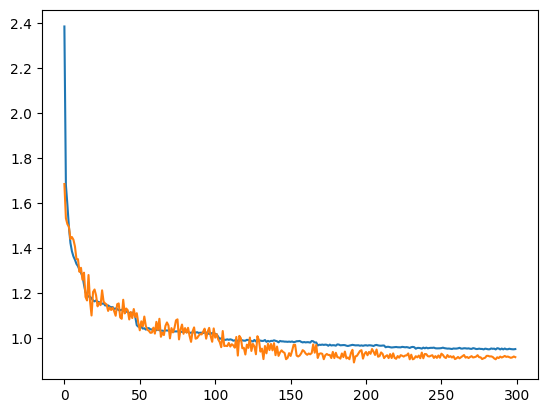

In [17]:
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()

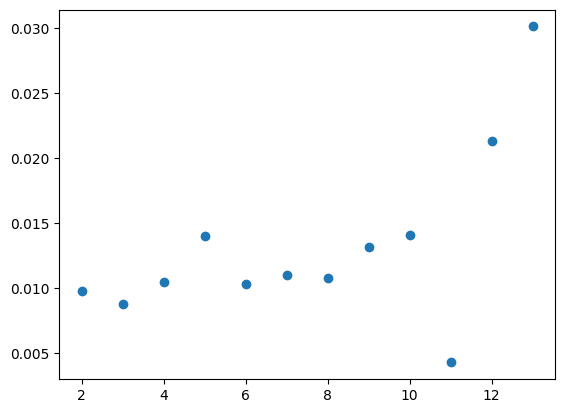

In [18]:
MSE_col = np.mean((preds_total[:,:,1]-y_test.to_numpy())**2,axis=0)
x=np.arange(2,np.size(MSE_col)+2)
plt.figure()
plt.scatter(x,MSE_col)
plt.show()

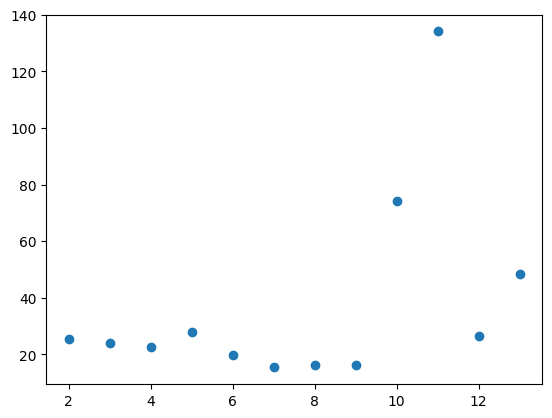

In [19]:
error_percent = 100*np.divide(np.abs(preds_total[:,:,1]-y_test.to_numpy()),y_test.to_numpy())

err_perc_col = np.mean(error_percent,axis=0)

plt.figure()
plt.scatter(x,err_perc_col)
plt.show()